## Model ensemble generator for Gottesacker 
Chloé FANDEL 2020 (cfandel@email.arizona.edu)

***
Environment: GK2

#### File structure:

**project folder:**
<br>*modules and templates needed to run model:*
- ensemble_generator.ipynb:  model ensemble generator
- ensemble_viewer.ipynb:     model ensemble viewer
- mapping.py:                GemPy grid and plotting add-on
- manager.py:                miscellaneous extra GemPy functions
- sksin.py:                  SKS wrapper
- swmmpy.py:                 SWMM wrapper
- options_karst_template.m:  template SKS input file (replace variables with placeholders, must not have commas)
- swmm_template.inp:         template SWMM input file (replace sections with placeholders, must not have commas)
- swmm5.exe:                 SWMM executable (copy from EPA download)
- swmm5.dll:                 SWMM dll (copy from EPA download)

**project/input data folder:**
<br>*files needed to run model:*
- DEMraster.tif:        DEM to be used to set model grid (should be rectangular)
- DEMraster_mask.tif:   DEM to be used to clip model to an irregular polygonal XY extent
- all_points.csv:       all available GemPy input data points 
- Qobs.csv:             observed spring discharge timeseries
- baseflow.txt:         distributed baseflow into model 
- rainfall.txt:         distributed rainfall over model
- grid.csv:             grid information for distributed inflows
- base.inp:             input file for calibrated reference model
- base.out:             output file for calibrated reference model

**project/output data folder:**
<br>*files created during model run:*
<br>Note: each of these files will have a model run identifier prefix, in the format:
<br>*gp00sks000swmm000* indicating the GemPy, SKS, and SWMM run numbers
- pars.csv:             Summary of parameter choices for current model iteration
- interfaces.csv:       GemPy input interfaces csv file (must have columns:   X, Y, Z, formation)
- orientations.csv:     GemPy input orientations csv file (must have columns: X, Y, Z, azimuth, dip, polarity, formation)
- geo.gslib:            GemPy output/ SKS input gslib file indicating formation number for each cell (one copy sent to 
- options_karst.m:      SKS input file with parameter settings
- output_SKS_simpleNodes.txt: SKS output file with two-(or three)column list of node coordinates (X, Y, (Z))
- output_SKS_simpleElevs.txt: SKS output file with one-column list of node elevations (if 2D model)
- output_SKS_simpleLinks.txt: SKS output file with two-column list of links (fromNode, toNode)
- output_SKS_springNodes.txt: SKS output file with three-column list of spring node coordinates (X, Y, Z)
- GK.inp:               SWMM input text file (see SWMM doc for formatting & parameter explanations)
- GK.out:               SWMM binary output file
- GK.rpt:               SWMM text report file

**SKS folder:**
<br>*These files live in the separate SKS repository, which is not public yet.
SKS takes and creates files that must have pre-set names, so these files must be copied to/from the correct folder without their prefix:*
- geo.gslib:                  place in SKS/project/input_SKS folder
- options_karst.m:            place in SKS/project folder with run_SKS.m script
- output_SKS_simpleNodes.txt: take from SKS/project/output_SKS folder
- output_SKS_simpleElevs.txt: take from SKS/project/output_SKS folder
- output_SKS_simpleLinks.txt: take from SKS/project/output_SKS folder
- output_SKS_springNodes.txt: take from SKS/project/output_SKS folder
***

### Setup
Import packages, set file structure, assign variables.
<br> **Package install notes:** It is crucial to create a new environment and install gdal FIRST, using conda. Then afterwards install all other packages, especially those using gdal, such as pysheds, and those with complicated dependencies, such as gempy.
1. Using Anaconda Prompt, create a new environment with gdal installed:
<br>`conda create -n env_name_here -c conda-forge gdal`
2. Install rasterio:
<br>`conda config --add channels conda-forge`
<br>`conda install rasterio`
3. Install pysheds:
<br>`conda install pysheds`
4. Install any other packages needed for project (including gempy, which should be installed AFTER gdal).



In [1]:
# Suppress FutureWarnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import packages:
import sys, os
import shutil 
from copy import copy
import importlib
import subprocess as sb
import pickle
import random
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn import cluster
import gempy as gp
import karstnet as kn
import networkx as nx
from swmmtoolbox import swmmtoolbox as st
import theano
import gdal
import geopandas as gpd
from shapely import geometry as shg
from shapely import ops as sho
import shapely.speedups

#Import local modules:
import mapping           #gempy mapping module add-on
import swmmpy as sp      #swmm wrapper
import sksin             #sks wrapper
import manager           #process manager

#Embed matplotlib figures into notebooks:
%matplotlib inline

#Disable some pandas & numpy warnings (CAUTION!!!!!):
pd.options.mode.chained_assignment = None  #this suppresses the pandas warning that happens when you use certain forms of selection & lookup - I *think* what I am doing is OK
warnings.filterwarnings("ignore", message="numpy.dtype size changed") #these suppress warnings due to updates - shouldn't affect performance (see https://stackoverflow.com/questions/40845304/runtimewarning-numpy-dtype-size-changed-may-indicate-binary-incompatibility)
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [12]:
#Set paths and filenames:
#note: paths for subprocess module need to have forward slashes not backslashes (why?!)
#note: fixed paths are called '_path', filenames that may be modified and stored in various places are called '_file'

ID           =  'test'                                                      #start of ensemble name string (will be added to during iteration)

#Paths:
input_path   =  r'C:\Users\Chloe\Documents\GitHub\gottesacker\input'        #path to input data folder
output_path  =  r'C:\Users\Chloe\Documents\GitHub\gottesacker\output'       #path to output data folder
matlab       = 'C:/Program Files/MATLAB/R2017b/bin/matlab.exe'              #path to MATLAB exe (forward slashes, no leading r)
swmm         =  'swmm5.exe'                                                 #path to SWMM executable
sks_path     = 'C:/Users/Chloe/Documents/GitHub/sks'                        #path to folder with SKS MATLAB scripts
sks_output   =  r'C:\Users\Chloe\Documents\GitHub\sks\output_SKS'           #path to SKS output folder 

#GemPy files:
dem_path           = os.path.join(input_path, 'DEMraster50_251x200.tif')    #DEM to be used to set model grid (should be rectangular)
points_path        = os.path.join(input_path, 'GK_all_points.csv')          #file with all geologic data points (must have columns: ID, X, Y, Z, formation, azimuth, dip, polarity, interface, overturned, erosion, source, type, use, order)
reference_path     = os.path.join(input_path, 'GK_reference_points.txt')    #reference points for plotting (must have 4 columns: ID, X, Y, Z)
geol_mask_path     = os.path.join(input_path, 'georaster50_mask_251x200.tif') #raster file of true geologic map (can be used to clip arrays to XY extent)
basin_mask_path    = os.path.join(input_path, 'DEMraster50_basinmask_179x139.tif') #raster cropped to catchment (see code in manual_testing.ipynb)
paraview_mask_path = os.path.join(input_path, 'DEMraster50_PVmask_251x200.tif') #raster file to crop to for visualization purposes
interfaces_file    = 'interfaces.csv'                 #name of interfaces csv file to be created (will have columns:   X, Y, Z, formation)
orientations_file  = 'orientations.csv'               #name of orientations csv file to be created (will have columns: X, Y, Z, azimuth, dip, polarity, formation)
gslib_file         = 'geo.gslib'                      #name of gslib file to be created (will have GeoModeller format)
#model_file         = 'geo_model'                      #name of gempy model file to be created (with pickle)

#SKS files:
sks_template_file  = os.path.join(input_path, 'options_karst_template.m')       #path to template sks options_karst.m file
sks_input_path     = os.path.join(sks_path,   'options_karst.m')                #where to save new options_karst.m file
sks_geo_path       = os.path.join(sks_path,   'input', gslib_file)              #path to geology file SKS will use (generated by GemPy)
spring_path        = os.path.join(sks_path,   'input', 'springs_correctedXYZ.txt') #path to spring coordinate file (should be same for all models)
nodes_file         = 'SKS_nodes.dat'                                            #name to save SKS node coord file to (compatible w/ karstnet)
links_file         = 'SKS_links.dat'                                            #name to save SKS links file to (compatible w/ karstnet)
sks_nodes_path     = os.path.join(sks_output, 'output_SKS_nodes.dat')           #path to SKS-generated complex nodes file
sks_links_path     = os.path.join(sks_output, 'output_SKS_links.dat')           #path to SKS-generated complex links file
base_nodes_file    = os.path.join(input_path, 'base_nodes.dat')                 #path to Zhao's nodes file
base_links_file    = os.path.join(input_path, 'base_links.dat')                 #path to Zhao's links file

#SWMM files:
#Note: the baseflow & rainfall files are too large to store on GitHub for this project
swmm_template_file  = os.path.join(input_path, 'swmm_template_auto.inp')    #path to template SWMM .inp file to import
swmm_inputfile      = ID + '.inp'                                           #filename to write new .inp file to
swmm_reportfile     = ID + '.rpt'                                           #filename to write .rpt file to
swmm_outputfile     = ID + '.out'                                           #filename to write .out file to
#sc_poly_path        = os.path.join(data_path, 'GK_subcatchments.shp')       #path to base model subcatchment shapefile
#sc_data_path        = os.path.join(data_path, 'GK_subcatchments.csv')       #path to base model subcatchment data file
#sc_raster_path      = os.path.join(data_path, 'subcatchments_raster.tif')   #raster file for base model subcatchments
rainfall_path       = os.path.join(input_path, 'rainfall.txt')              #fast-flow recharge input timeseries distributed in a 100mx100m cell grid
baseflow_path       = os.path.join(input_path, 'baseflow.txt')              #slow-flow recharge input timeseries distributed in a 100mx100m cell grid
grid_path           = os.path.join(input_path, 'grid100.csv')               #recharge input 100mx100m cell grid
Qobs_path           = os.path.join(input_path, 'Qobs.csv')                  #observed spring discharge timeseries at QS,QE,QA  
swmm_base_path      = os.path.join(input_path, 'base.inp')                  #base model swmm input file (with rainfall in mm and baseflow in mm)


### Parameter options 

*ParLists* is a dictionary for each model (gempy, sks, swmm) with an entry for each parameter that can be chosen for that model. The key is a string identifying the parameter, and the value is a list of possible values (no more than 10) that can be assigned to that parameter. 
<br>*ParInd* is a dictionary with the same keys as ParLists, where each value is either:
- if the parameter is fixed: 
<br>an integer corresponding to the index in the preceding parameter list of the desired parameter value
- if the parameter should be randomly chosen from the list at each iteration: 
<br>the string *'vary'*
- if the parameter choice is linked to a preceding parameter choice:
<br>a string indicating the name of the parameter to link to

**Example:** 
sksParInd = {'FMAaqf':        2,
             'FMAfra':        'vary',
             'minStrike':     'vary',
             'maxStrike':     'minStrike'} 
means that the models in the resulting ensemble will all have the following parameter values:
- FMAaqf         = the value at position 2 (in this case, 3)
- FMAfra         = randomly chosen each iteration 
- minStrike      = randomly chosen each iteration 
- maxStrike      = the value with the same index as minStrike (ex: if minStrike is [35,105], maxStrike will be [45,115]

In [62]:
#Miscellaneous options:
show         = False                                #set whether to plot results or no
nruns        = {'gempy':1, 'sks':10, 'swmmRound1':4, 'swmm':5}    #set number of iterations to run for each section

#########################
#GemPy options:
gpParLists = {'unitNames':  [['Garschella', 'Schrattenkalk', 'Drusberg']],  #list options for unit name strings youngest to oldest (must match units present in interface and orientation data files)
              'isFault':    [True, False],                                  #list options for whether a fault is present
              'faultNames': [['faultB1','faultA1']],                        #list options for fault unit name strings youngest to oldest
              'zres':       [10, 26, 52, 55, 65, 110, 130, 143],            #list options for vertical resolution (number of layers). 26 gives roughly 50x50x50m cubic cells
              'dataSource': ['best','Goldscheider']}                        #list options for which data to select

gpParInd   = {'unitNames':  0,
              'isFault':    1,
              'faultNames': 0,
              'zres':       2,
              'dataSource': 0}          #select whether to fix or vary each parameter (enter either index of desired value, or 'vary')

allfm      = ['faultB1','faultB2','faultA1','fault A2', 
              'Quaternary', 'Amdener',  'Garschella', #list of strings indicating all formations present in the allpts input file
              'Schrattenkalk', 'Drusberg', 'Kieselkalk']

##########################
#SKS options: 
sks_placeholders = ['zres', 'delz',
                    'FMAout', 'FMAaqf', 'FMAaqc', 'FMAfra', 'FMAflt', 'FMAhor', 'Cmult',
                    'inlettype', 'permuteInlets', 'nRandInlets', 'inletfactor',
                    'permuteSpgs', 'altSpgs','crop',
                    'fracsource', 'nfrac', 'minStrike', 'maxStrike', 'minDip', 'maxDip', 
                    'fracfactor', 'fractype', 'fracL',
                    'plugtype', 'nplug', 'rballs']

sksParLists = { 'FMAaqf':        [1,   2,   3,   4,   5,   6,  7,    8,    9,    10],
                'FMAfra':        [1.2, 1.5, 2,   3,   5,   8,  10,   12,   15,   20],  
                'Cmult':         [1.2, 1.5, 2,   2.5, 3,   3.5, 4,   4.5,  5],
                'fixedInlets':   ['top5','top9','top13'],
                'permuteInlets': [0,   1],
                'nRandInlets':   [0,   1,   2,   3,   4,   5,   6,   7,    8,    9],
                'inletFactor':   [[1,1,1,1,1],   [1,2,7],  [1,1,2,3,3]],
                'permuteSpgs':   [0,   1],
                'altSpgs':       [0,   1],
                'nfrac':         [50,  100, 200, 400, 600, 700, 900, 1000, 1500, 2000],
                'minLen':        [1,   2,   5,   10,  15,  25,  50,  100,  150,  300],
                'maxLen':        [350, 400, 500, 600, 700, 800, 900, 1000, 2000, 5000],
                'minStrike':     [[35,105],  [35,105,70], [120,110,145,35]],    #[0,25,35,115,135,145,155]
                'maxStrike':     [[45,115],  [45,115,80], [130,120,155,45]],    #[15,35,115,135,145,155,180]
                'minDip':        [[80,80],   [80,80,80],  [80,80,80,80]],       #[70,70,40,70,75,80,65]
                'maxDip':        [[90,90],   [90,90,90],  [100,100,100,100]],   #[90,78,90,90,90,90,90]
                'fracFactor':    [[8,2],  [6,3,1], [5,3,1.5,0.5]],              #[7.5,5.625,14.375,22.5,15,8.125,26.875 ]
                'plugType':      [0, 1, 2],
                'nPlug':         [0, 3, 5, 7, 10, 20],
                'minr':          [0.01, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5],
                'maxr':          [5, 7, 10, 15, 20]}

sksParInd   = { 'FMAaqf':        1,
                'FMAfra':        'vary',   #was fixed at 4
                'Cmult':         2,
                'fixedInlets':   'vary',
                'permuteInlets': 1,
                'nRandInlets':   0,
                'inletFactor':   0,
                'permuteSpgs':   1,
                'altSpgs':       1,
                'nfrac':         'vary',
                'minLen':        'vary',
                'maxLen':        'vary',
                'minStrike':     'vary',
                'maxStrike':     'minStrike',
                'minDip':        'minStrike',
                'maxDip':        'minStrike',
                'fracFactor':    'minStrike',
                'plugType':      0,
                'nPlug':         0,
                'minr':          0,
                'maxr':          2}

######################################        
#SWMM options:
#TO-DO:
#update SWMM parameters & clarify that these are only for fixed parameters
#conduit diameter will be optimized later

swmm_placeholders  = ['raingages', 'subcatchments', 'subareas', 'infiltration', 'junctions', 'outfalls', 'conduits',
                      'xsections', 'inflows', 'timeseries', 'report', 'coordinates']  #placeholder strings to be replaced with data

swmmParLists = {'manningN': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]}
                
swmmParInd   = {'manningN': 0}

### Geologic model (GemPy)

Starting GemPy run 0: testgp01020 with parameter values:
 {'unitNames': ['Garschella', 'Schrattenkalk', 'Drusberg'], 'isFault': False, 'faultNames': ['faultB1', 'faultA1'], 'zres': 52, 'dataSource': 'best'}

 Data source: best
Grid dimensions: 
xmin: 578287.5     xmax: 590837.5     xres: 251          dx: 50.0 
ymin: 5240062.5    ymax: 5250062.5    yres: 200          dy: 50.0 
zmin: 800          zmax: 2230.0       zres: 52           dz: 27.5
[ 578287  590837 5240062 5250062] [200 251]
Cropped raster to geo_model.grid.extent.
[ 578287  590837 5240062 5250062] [200 251]
storing converted file...
obacht
Fault offset relationships:
           strat  Basement
strat     False     False
Basement  False     False
Compiling theano function...
Compilation Done!
Done with GemPy runs.


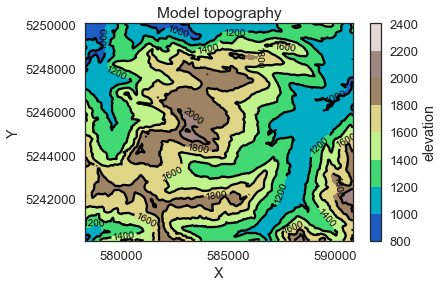

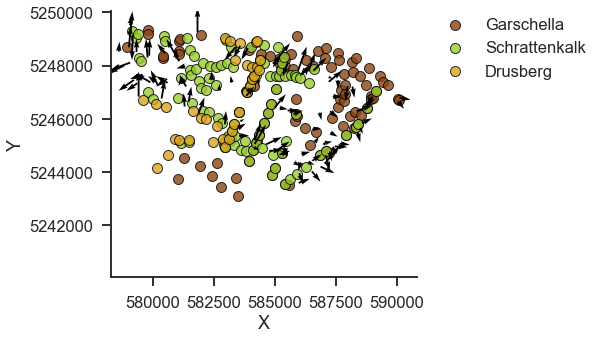

In [16]:
importlib.reload(manager)
importlib.reload(mapping)

#Set up iterations & ID string:
gpIDs   = []         #create empty list to store gempy run ID strings
gpPars  = {}         #create empty dictionary to store current run parameter values
    
allpts = pd.read_csv(points_path,na_values='na')  #import all data points to pandas df

for i in range(nruns['gempy']):         #loop over number of desired GemPy iterations
    #Select parameters for current run and store information:
    #select a parameter value from the list of options (created above), based on the index in gpPars
    gpParKey = ''                      #create empty string to store current run parameter key string
    gpRunPars = {}                     #create empty dictionary to store current run parameter values
    for par,ind in gpParInd.items():   #loop over dictionary items (keys and values)
        if ind != 'vary':                   #if the parameter is not being varied
            val = gpParLists[par][ind]      #get parameter value specified by index
            gpRunPars[par] = val            #add to dictionary of parameter values for current run
            gpParKey = gpParKey + str(ind)  #append index to parameter key string
        else:                                               #if the parameter is being varied
            ind = random.randint(0,len(gpParLists[par])-1)  #select a random integer in the range of available values
            val = gpParLists[par][ind]                      #get parameter value specified by index
            gpRunPars[par] = val                            #add to dictionary of parameter values for current run
            gpParKey = gpParKey + str(ind)                  #append to parameter key string
    gpRunID = ID + 'gp' + str(gpParKey)                     #create current run ID string
    gpIDs.append(gpRunID)                                   #store in list of all gempy run IDs
    gpPars[gpRunID] = gpRunPars                             #store current run parameters dic of all gempy run parameters
    print('Starting GemPy run ' + str(i) + ': ' + gpRunID + ' with parameter values:\n', gpRunPars)

    #Select input data (from list of all possible points):
    allpts = pd.read_csv(points_path,na_values='na')              #import all data points to pandas df
    order = pd.DataFrame([allfm,np.arange(len(allfm))], index=['formation','order']).T #create a df with age order info
    allpts = allpts.merge(order, on='formation', how='left')      #add order data to allpts
    allpts.sort_values(by='order', inplace=True)                  #sort by age order
    allpts.Z = allpts.Z - allpts.depth                            #for points picked from x-sections, change elevation to be the land surface - depth to point
    allpts.Z[allpts.erosion > 0] = allpts.Z + allpts.erosion      #for points picked from eroded land surfaces, increase the elevation by the estimated erosion depth
    allpts.azimuth = allpts.azimuth + 90                          #convert strike to azimuth (dip direction)
    
    dataSource = gpRunPars['dataSource']            #get data source for this run
    if dataSource == 'best':  
        print('\n Data source: ' + gpRunPars['dataSource'])
        allpts.use[allpts.erosion > 0] = 'n'        #don't use data that needs to be erosion-corrected
        allpts.use[allpts.type=='xsec'] = 'y'       #do use data from cross-sections
        allpts.use[allpts.overturned=='y'] = 'n'    #don't use data from overturned folds 
        allpts.use[allpts.ID.isin(['S-008','S-015','S-016','S-063','S-064','S-068','S-240','S-241','S-242',
                                   'S-246','S-266','S-272','S-274','S-275','S-276','S-277','S-279','S-280'
                                   'S-281','S-282','S-283'])] = 'y'  #turn on select points that seem useful
        allpts.use[allpts.ID.isin(['SD-110'])] = 'n' #turn off select points too close to one another
    if dataSource == 'Goldscheider':               
        print('\n Data source: ' + gpRunPars['dataSource'])
        allpts.use = 'n'                                           #remove all points
        allpts.use[allpts.source=='Goldscheider 1997'] = 'y'       #add back in only Goldscheider points
        
    #TO-DO:
    #Insert option to randomly perturb z of data points here
    
    #Select other parameters:
    unitNames = gpRunPars['unitNames']     #get list of unit names from par dic
    isFault = gpRunPars['isFault']         #get whether fault is present from par dic

    if isFault==True:
        faultNames = gpRunPars['faultNames']
        allNames = faultNames+unitNames                             #add fault names to list of all unit names
        allpts.use[allpts.fault=='y'] = 'y'                         #add fault data
        allpts.use[allpts.ID.isin(['F-22','F-23','F-24'])] = 'n'    #turn off select points too close to one another or not useful
    else:
        allpts.use[allpts.fault=='y'] = 'n'                         #don't use fault data
        allNames = unitNames
        
    #Create & save input data files:
    orfile  = os.path.join(output_path, gpRunID+orientations_file) #orientations filepath (with model ID)
    intfile = os.path.join(output_path, gpRunID+interfaces_file)   #interfaces filepath (with model ID)
    manager.create_gp_input(allpts, allNames, orfile, intfile)   #create orientations and interfaces files for GemPy


    ##############################################################################################################################
    #RUN GEMPY:
    ##############################################################################################################################
    
    #Get and assign model grid and resolution automatically based on DEM raster file:
    dem,dema,xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres = mapping.importDEM(dem_path,show=False) 
    zmin = 800                  #manually set zmin so that model extends below land surface - must be integer
    zres = gpRunPars['zres']    #get vertical (z) resolution (number of layers) from parameter dic & manually assign it (this has nothing to do with dem resolution)
    dz = (zmax-zmin)/zres       #calculate z cell height (kind of like contour interval)
    grid_info = [xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz]  #lump grid and resolution info into one list to use later
    print('Grid dimensions: \nxmin: {:<12} xmax: {:<12} xres: {:<12} dx: {} \nymin: {:<12} ymax: {:<12} yres: {:<12} dy: {} \nzmin: {:<12} zmax: {:<12} zres: {:<12} dz: {}'.format(
            xmin,xmax,xres,dx, ymin,ymax,yres,dy, zmin,zmax,zres,dz))

    skip = False                 #option to only run parameter selection and not model (for debugging)
    if skip == False:
        
        geo_model = gp.create_model(gpRunID)                                          #create model object
        gp.init_data(geo_model, [xmin,xmax, ymin,ymax, zmin,zmax], [xres,yres,zres],  #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM but must be integers)
                    path_o = orfile,                                                  #csv file for orientation points: col names are case sensitive, must include at least one point per unit t
                    path_i = intfile)                                                 #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit (except faults)

        if isFault==True:
            seriesDic = {}                 #create an empty dictionary to store series info
            for fault in faultNames:       #loop over faults
                seriesDic[fault] = fault   #assign each fault to its own series (must be youngest to oldest)
            seriesDic['strat'] = unitNames #assign all lith units to one series (must be youngest to oldest)
            gp.map_series_to_surfaces(geo_model, seriesDic)  #set the correct order of series, youngest to oldest - each fault needs its own series, but units can all be lumped into one series
            geo_model.set_is_fault(faultNames)                          #set the fault series to be recognized by gempy as faults
            geo_model.set_is_finite_fault(faultNames,toggle=True)       #set the fault series to be finite
        else:
            gp.map_series_to_surfaces(geo_model, {'strat': unitNames})  #set the correct order of series, youngest to oldest

        #Set grids:
        geo_model.set_topography(source='gdal', filepath=dem_path)      #load surface topography from DEM
        geo_model.grid.set_active('topography')                         #need to activate both topo and regular grid to visualize in VTK
        geo_model.grid.set_active('regular')

        #Set custom colors for different units (optional):
        surfaces = geo_model.surfaces                                                #get surfaces in the model
        colordic = {'Garschella':    matplotlib.colors.cnames['saddlebrown'],        #create custom color dictionary
                    'Schrattenkalk': matplotlib.colors.cnames['yellowgreen'],
                    'Drusberg':      matplotlib.colors.cnames['goldenrod'],
                    'basement':      matplotlib.colors.cnames['rebeccapurple']} 
        surfaces.colors.change_colors(colordic)                                      #assign new colors

        #View model setup (optional):
        if show==True:
            gp.plot.plot_data(geo_model, direction='z') #plot a map view of the data points
            print('Fault offset relationships:\n', geo_model.faults.faults_relations_df) #view which faults offset each other (each row lists which columns it offsets)
            geo_model.surfaces                          #see order of surfaces (series and formations)
        
        #Calculate model: (only need to interpolate once)
        #if using topography, need to set output='geology'
        #for high-resolution models with many data points, set theano_optimizer='fast_run' instead of 'fast_compile' - this takes longer to interpolate, but then afterwards runs faster & avoids theano memory error during compute_model()
        gp.set_interpolation_data(geo_model, output='geology', theano_optimizer='fast_run') #compile theano and interpolate the input data
        sol = gp.compute_model(geo_model, compute_mesh=False)   #compute the model from the data - returns an output (sol) which includes lith and faults, each with two arrays, one for the id of the formation in each cell, one with orientations in each cell
        #to see 3D VTK visualization of interfaces, set compute_mesh=True. To return only the lith block, set compute_mesh=False (this works even if xres ≠ yres)

        #Format & export data:
        lithZcrop  = mapping.crop2topo(  sol, dem_path)   #crop to land surface (only works if the xy resolution of the DEM is the same as the xy resolution of the model)
        lithXYcrop = mapping.crop2raster(sol, geol_mask_path,     a=lithZcrop)   #crop topo-cropped array to extent of geol map from raster
        lithPVcrop = mapping.crop2raster(sol, paraview_mask_path, a=lithZcrop, nanval=0)   #crop topo-cropped array to desired extent set from raster
        mapping.export2gslib(lithXYcrop, os.path.join(output_path, gpRunID+gslib_file), sol.grid.regular_grid)    #export cropped lith block
        mapping.export2vtk(sol, os.path.join(output_path, gpRunID+'VTK'), a=lithPVcrop)  #export to vtk for visualization
        mapping.export2gslib(sol.geological_map, os.path.join(output_path, gpRunID+'_map.gslib'),  geo_model.grid.topography)    #export geologic map to gslib file

print('Done with GemPy runs.')

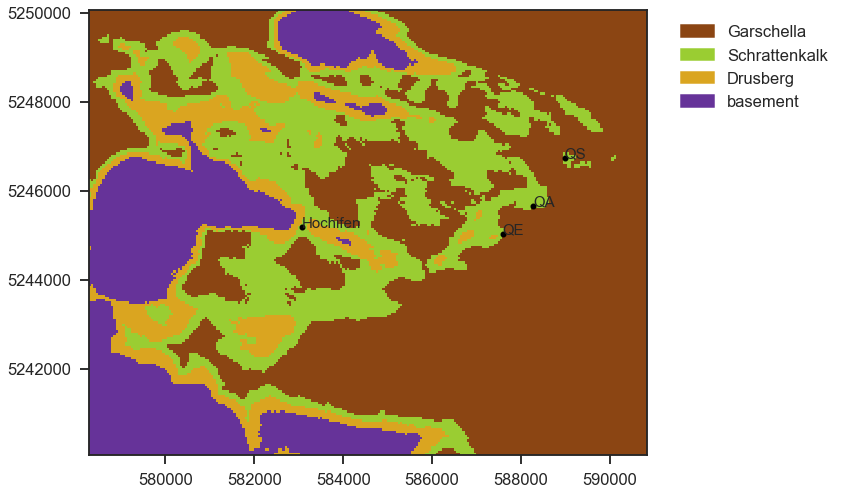

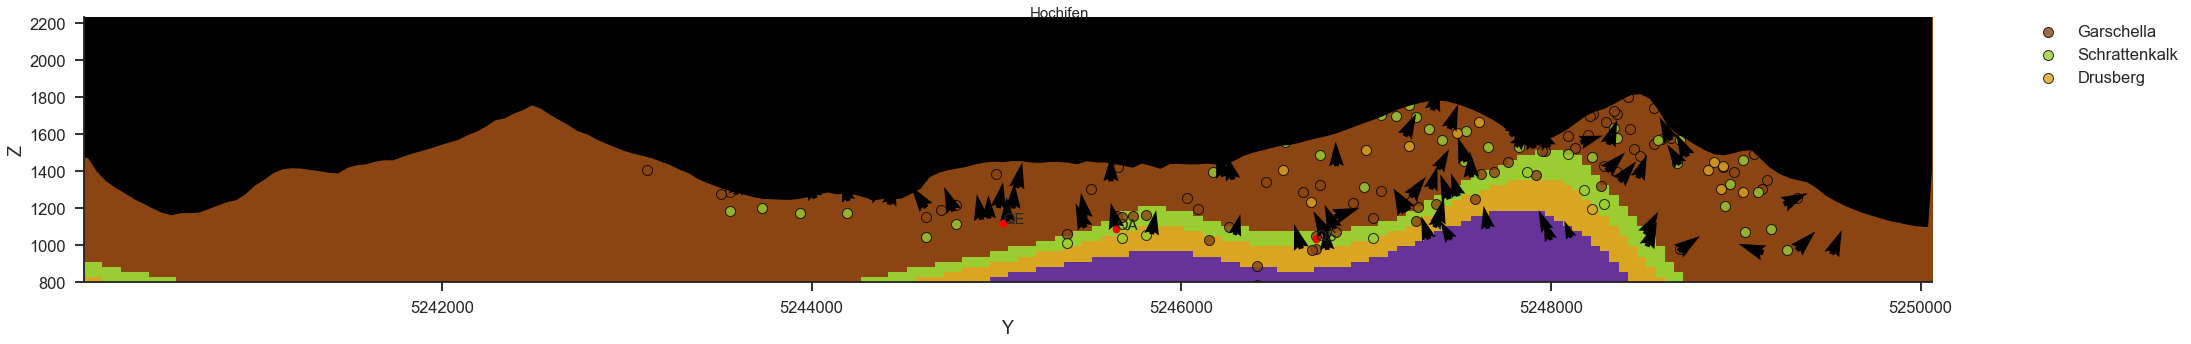

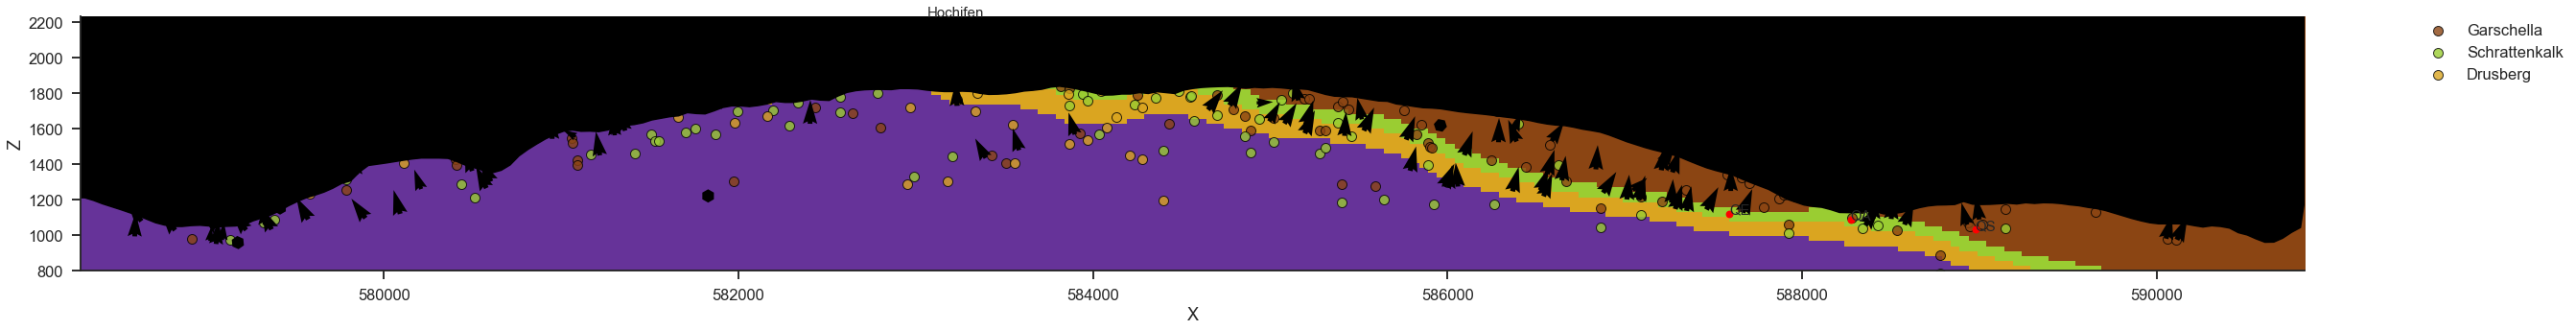

In [23]:
#Optional: Plot model maps and cross-sections:
importlib.reload(mapping)
    
#Plot simple geologic map in 2D:    
show = True
if show==True:
    mapping.plot_map(os.path.join(output_path, gpRunID+'_map.gslib'), geo_model, plot_data=False, ref_points=reference_path)  #plot map

#Open 3D VTK viewer:
show=False
if show==True:
    ver_s, sim_s = gp.get_surfaces(interp_data,lith[0][1], original_scale=True)
    gp.plot_surfaces_3D_real_time(interp_data, ver_s, sim_s)
    
#PLot diagonal cross-sections:
#need at least two points, A and B, with x and y coordinates for each (from ArcMap), or can skip assigning coordinates and assign row,col directly
show = False
ref  = True
if show == True:
    #Set start and end coordinates:
    C = [583975.119, 5244365.344];   D = [585456.180, 5248350.638]
    G = [585417.484, 5243468.735];   H = [589363.356, 5246778.944]
    I = [583987.502, 5247524.400];   J = [585690.893, 5249735.263]

    #Plot map & x-sections:
    m  = mapping.importgslib(os.path.join(output_path,gpRunID+'_map.gslib'), geo_model.grid.topography)  
    m = np.flipud(m)
    f1,ax1,f2,ax2 = mapping.plotXsection([C,G,I],[D,H,J], 
                                 [['C','D'],['G','H'],['I','J']], 
                                 geo_model, lithXYcrop, m, vscale=1)
    if ref == True:
        #Plot data points:
        pts = allpts[allpts.use=='y']
        pts['col'] = (pts.X - xmin)//dx
        pts['row'] = yres - ((pts.Y - ymin)//dy)
        ax1.scatter(pts.col,pts.row, s=4, c='k')
    
#Plot orthogonal cross-sections:
show = True
ref  = True
if show == True:
    #North-South
    #notes: QE: 186, QA: 199, QS: 213
    gp.plot.plot_section(geo_model, cell_number=199, direction='x', show_data=True)  #plot a cross-section along a primary axis
    if ref == True:
        ref_pts = pd.read_csv(reference_path)                           #get reference points from file
        plt.scatter(ref_pts.Y,ref_pts.Z, s=40, c='r')                   #plot as points 
        for i,pt in ref_pts.iterrows():
            plt.annotate(pt.Name, (pt.Y,pt.Z), fontsize=15)     #add labels to reference points
        
    #East-West
    #notes: QE: 99, QA: 111, QS: 133)
    gp.plot.plot_section(geo_model, cell_number=111, direction='y', show_data=True)
    if ref == True:
        plt.scatter(ref_pts.X,ref_pts.Z, s=40, c='r')                   #plot as points 
        for i,pt in ref_pts.iterrows():
            plt.annotate(pt.Name, (pt.X,pt.Z), fontsize=15)     #add labels to reference points
            

### Conduit network (SKS)

Run SKS in MATLAB to create an enemble of conduit networks set into the GemPy geologic structure. <br>

**Notes:**
- template input file (options_karst_template.m) MUST NOT have commas
- order of placeholder list and data filename list must be the same
- to add an editable parameter, replace that parameter value with a unique placeholder in the template file, then define it in Python and add it to the placeholders and data lists
- the files in the SKS folder will represent the last run - for each run the input and output files get copied to the Python data folder

In [63]:
#sks_placeholders = ['FMAout', 'FMAaqf', 'FMAaqc', 'FMAfra', 'FMAflt', 'FMAhor', 'Cmult',
#                    'inlettype', 'permuteInlets', 'nRandInlets', 'inletfactor',
#                   'permuteSpgs', 'altSpgs','crop',
#                   'fracsource', 'nfrac', 'minStrike', 'maxStrike', 'minDip', 'maxDip', 
#                    'fracfactor', 'fractype', 'fracL']

#Set up parameter key string tracking & select parameters:
sksIDs   = []    #create empty list to store gempy run ID strings
sksPars  = {}   #create empty dictionary to store current run parameter values

for i in range(nruns['gempy']):                #loop over GemPy runs
    gpRunID = gpIDs[i]                      #get Gempy ID for current run
    shutil.copyfile(os.path.join(output_path,gpRunID+gslib_file), sks_geo_path)   #copy current GemPy model gslib file to the SKS input folder                
    
    for j in range(nruns['sks']):               #loop over SKS runs
        #Select parameters for current run and store information:
        #select a parameter value from the list of options (created above), based on the index in gpPars
        sksParKey = ''                         #create empty string to store current run parameter key string
        sksRunPars = {}                        #create empty dic to store current run parameter values
        sksRunInds = {}                        #create empty dic to store current run parameter indices
        for par,ind in sksParInd.items():      #loop over dictionary items (keys and values)
            if ind == 'vary':                                #if the parameter is being varied
                ind = random.randint(0,len(sksParLists[par])-1)     #select a random integer in the range of available values
                val = sksParLists[par][ind]                         #get parameter value specified by index
                sksRunPars[par] = val                               #add to dictionary of parameter values
                sksParKey = sksParKey + str(ind)                    #append to parameter key string
                sksRunInds[par] = ind                               #store the new random index
            elif ind in sks_placeholders:        #if the parameter is linked to another parameter
                ind = sksRunInds[ind]            #get the value for the linked parameter (must have already been assigned)
                val = sksParLists[par][ind]      #get parameter value specified by index
                sksRunPars[par] = val            #add to dictionary of parameter values
                sksParKey = sksParKey + str(ind) #append index to parameter key string
                sksRunInds[par] = ind            #store the index            
            else:                                #if the parameter is not being varied
                val = sksParLists[par][ind]      #get parameter value specified by index
                sksRunPars[par] = val            #add to dictionary of parameter values
                sksParKey = sksParKey + str(ind) #append index to parameter key string
                sksRunInds[par] = ind            #store the index
                
        
        sksRunID = gpRunID + 'sks' + str(sksParKey)                 #create current run ID string
        sksIDs.append(sksRunID)                                     #append to list of sks run IDs
        sksPars[sksRunID] = sksRunPars                                   #append current run parameters to list of all sks parameters
        print('Starting SKS run ' + str(i) + '-' + str(j) + ': ' + sksRunID + ' with parameter values:\n', sksRunPars)
        
        skip = False
        if skip == False:
        #Define variables to be editable:
        #See options_karst.m and SKS documentation for detailed variable descriptions
            
            #FMA speeds:
            FMAout = 0.0011
            FMAaqf = sksRunPars['FMAaqf']          #get value from par dic
            FMAaqc = 1
            FMAfra = FMAaqf * sksRunPars['FMAfra']
            FMAflt = 1000
            FMAhor = FMAaqf * 3
            Cmult  = sksRunPars['Cmult']

            #Inlets:
            fixedInlets = sksRunPars['fixedInlets']
            shutil.copyfile(os.path.join(sks_path,'input','inlet_'+fixedInlets+'.txt'), os.path.join(sks_path,'input','inlets.txt'))   #copy desired inlet file to SKS input folder with correct name                
            inlettype = 2
            permuteInlets = sksRunPars['permuteInlets']
            nRandInlets   = sksRunPars['nRandInlets']
            inletFactor   = sksRunPars['inletFactor']

            #Outlets:
            permuteSpgs = sksRunPars['permuteSpgs']
            altSpgs     = sksRunPars['altSpgs']

            #Geology:
            crop = 0 

            #Fractures:
            #because there can be different numbers of families, if minStrike is set to vary, 
            #maxStrike, minDip, maxDip, and fracFactor will be chosen to be the same index as minStrike
            fracsource = 2
            nfrac      = sksRunPars['nfrac']
            minStrike  = sksRunPars['minStrike']    #the setting in minStrike determines what will be chosen for maxStrike, minDip, maxDip, fracFactor
            maxStrike  = sksRunPars['maxStrike']    
            minDip     = sksRunPars['minDip']       
            maxDip     = sksRunPars['maxDip']       
            fracFactor = sksRunPars['fracFactor']   
            fractype   = [0, 0, 0, 0, 0, 0, 0]
            minLen     = sksRunPars['minLen']
            maxLen     = sksRunPars['maxLen']
            fracL      = '[{}:0.1:{}]'.format(minLen,maxLen)
            
            #Plugs:
            plugType = sksRunPars['plugType']
            nPlug    = sksRunPars['nPlug']
            minr     = sksRunPars['minr']
            maxr     = sksRunPars['maxr']
            rBalls   = '[{} {}]'.format(minr,maxr)
                    
            #Group all parameters into a list (must be same length and order as placeholders define in options section)  
            sks_data     = [zres, dz,
                            FMAout, FMAaqf, FMAaqc, FMAfra, FMAflt, FMAhor, Cmult,
                            inlettype, permuteInlets, nRandInlets, inletFactor,
                            permuteSpgs, altSpgs, crop,
                            fracsource, nfrac, minStrike, maxStrike, minDip, maxDip, fracFactor, fractype, fracL,
                            plugType, nPlug, rBalls]

            #Write input file for current run, save a copy with the model number, and send one to SKS to run:
            run_input_file = os.path.join(output_path,sksRunID+'options_karst.m')         #create filepath to save input file with IDs
            sksin.write_input(sks_placeholders, sks_data, template_filename=sks_template_file, inputfile=run_input_file)  #write SKS options_karst.m file based on paramete
            shutil.copyfile(run_input_file, sks_input_path)  #copy the current iteration's input file to the SKS folder to be run

            #Run SKS:
            sksin.run_SKS(sks_path, matlab)             #run SKS in MATLAB as a subprocess

            #Save outputs to data folder:
            #shutil.copyfile(os.path.join(sks_output, spring_file),  os.path.join(data_path, sksRunID+spring_file))   #copy the current iteration's output files with the current run ID appended to the data folder
            shutil.copyfile(sks_nodes_path, os.path.join(output_path, sksRunID+nodes_file))    #copy the current iteration's output files with the current run ID appended to the data folder
            shutil.copyfile(sks_links_path, os.path.join(output_path, sksRunID+links_file))    #same for links filea

print('Done with SKS runs.')

Starting SKS run 0-0: testgp01020sks122110011296000000002 with parameter values:
 {'FMAaqf': 2, 'FMAfra': 2, 'Cmult': 2, 'fixedInlets': 'top9', 'permuteInlets': 1, 'nRandInlets': 0, 'inletFactor': [1, 1, 1, 1, 1], 'permuteSpgs': 1, 'altSpgs': 1, 'nfrac': 200, 'minLen': 300, 'maxLen': 900, 'minStrike': [35, 105], 'maxStrike': [45, 115], 'minDip': [80, 80], 'maxDip': [90, 90], 'fracFactor': [8, 2], 'plugType': 0, 'nPlug': 0, 'minr': 0.01, 'maxr': 10}
running SKS in MATLAB...
done
Starting SKS run 0-1: testgp01020sks162210011563111110002 with parameter values:
 {'FMAaqf': 2, 'FMAfra': 10, 'Cmult': 2, 'fixedInlets': 'top13', 'permuteInlets': 1, 'nRandInlets': 0, 'inletFactor': [1, 1, 1, 1, 1], 'permuteSpgs': 1, 'altSpgs': 1, 'nfrac': 700, 'minLen': 50, 'maxLen': 600, 'minStrike': [35, 105, 70], 'maxStrike': [45, 115, 80], 'minDip': [80, 80, 80], 'maxDip': [90, 90, 90], 'fracFactor': [6, 3, 1], 'plugType': 0, 'nPlug': 0, 'minr': 0.01, 'maxr': 10}
running SKS in MATLAB...
done
Starting SKS r

importing & simplifying network

Graph successfully created from file !

assigning springs by adding spring nodes and linking to closest junction node
importing unsimplified network
assigning springs by adding spring nodes and linking to closest junction node
importing & simplifying network

Graph successfully created from file !

assigning springs by adding spring nodes and linking to closest junction node
importing unsimplified network
assigning springs by adding spring nodes and linking to closest junction node
importing & simplifying network

Graph successfully created from file !

assigning springs by adding spring nodes and linking to closest junction node
importing unsimplified network
assigning springs by adding spring nodes and linking to closest junction node
importing & simplifying network

Graph successfully created from file !

assigning springs by adding spring nodes and linking to closest junction node
importing unsimplified network
assigning springs by adding spring nod

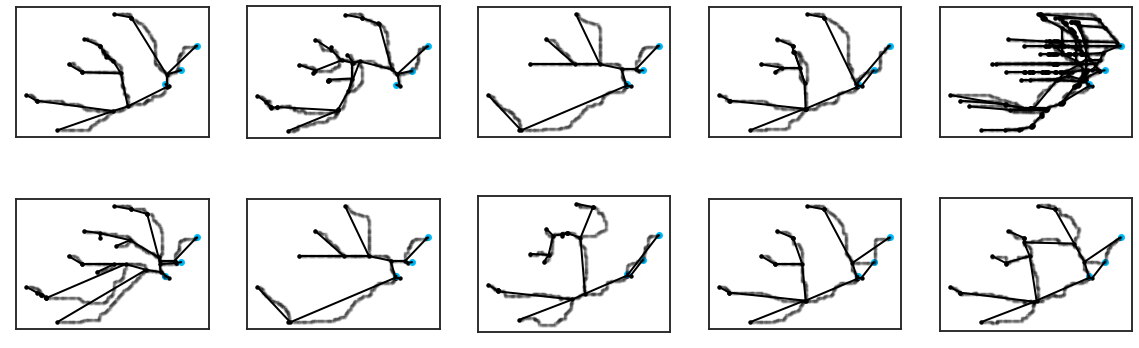

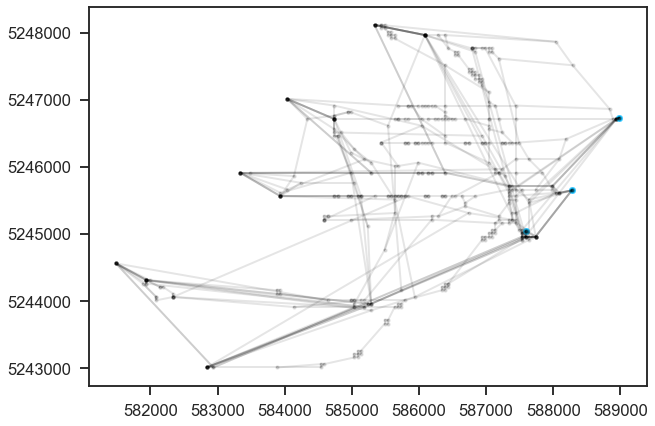

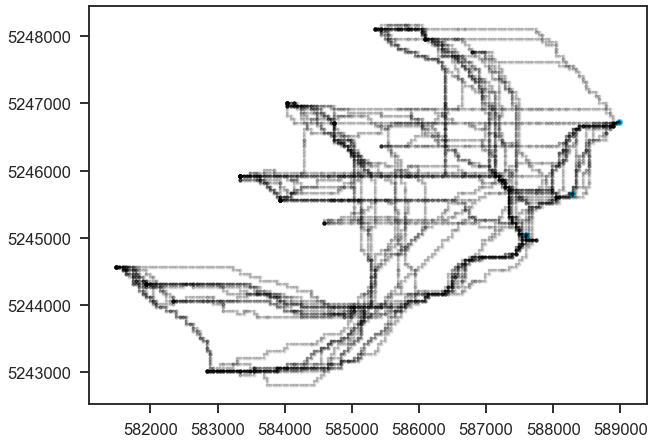

In [64]:
#Plot flattened map views of all networks generated:
f = plt.figure(figsize=(20,(math.ceil(len(sksIDs)/5))*5))                             #create an empty figure for the individual plots
f2 = plt.figure(figsize=(10,10))                            #create empty figure for the simple heatmap
ax2 = f2.add_subplot(111)                                   #add subplot axes
f3 = plt.figure(figsize=(10,10))                            #create empty figure for the complex heatmap
ax3 = f3.add_subplot(111)                                   #add subplot axes
for i in range(len(sksIDs)):                                #loop over sks ID indices
    sksID = sksIDs[i]                                       #get current ID
    nodef   = os.path.join(output_path,sksID+nodes_file)      #find name of desired file
    linkf   = os.path.join(output_path,sksID+links_file)      #find name of desired file
    #Simplified:
    [nodes,links] = sp.sks2swmm(nodef,linkf,spring_path, dim=3)  #sks2swmm(nodes_file, links_file, spring_file, dim=3, simple=False, elev_file=None)
    ax = f.add_subplot(math.ceil(len(sksIDs)/5)+1, 5, i+1)                              #add subplots in grid
    sp.plot_map(nodes,links, dim=2, fig=f,  ax=ax)                              #plot each individual conduit map
    sp.plot_map(nodes,links, dim=2, fig=f2, ax=ax2, c='k', a=1/len(sksIDs))     #plot heatmap of all iterations superimposed semi-transparently
    #Complex:
    [nodes, links] = sp.sks2swmm(nodef,linkf,spring_path, dim=3, simplify=False)    #sks2swmm(nodes_file, links_file, spring_file, dim=3, simple=False, elev_file=None)
    sp.plot_map(nodes,links, dim=2, fig=f,  ax=ax,  a=1/len(sksIDs))                      #plot each individual conduit map
    sp.plot_map(nodes,links, dim=2, fig=f3, ax=ax3, c='k', a=1/len(sksIDs))     #plot heatmap of all iterations superimposed semi-trans
    ax.get_xaxis().set_ticks([])                                                #remove subplot tick labels
    ax.get_yaxis().set_ticks([])
    #ax.set_title(sksID)                                                        #label each subplot with the name of corresponding SKS network
    #ax.set_aspect('auto')
    #plt.tight_layout()

### Flow model (SWMM)

**Functions:**
<br>- Imports SKS-generated conduit network
<br>- Writes SWMM project.inp files using a template (template.inp) - searches for placeholder strings in the template and replaces them with data from pandas dataframes. Dataframes can be created using swmmpy functions, or loaded from .csv files
<br>- Run SWMM using the specified project.inp file

**Notes:**
<br>- template.inp files must not have any commas in them (otherwise the importer thinks they are column breaks)
<br>- placeholders in template.inp files must not have any other characters (even spaces) in the same line
<br>- order of placeholder list and data filename list must be the same
<br>- common error: the template filename isn't correct, so the insert_data() function can't find the section where it's supposed to insert the data
<br>- different template files can be used for different levels of control
<br>- subcatchments can be provided as a shapefile and txt file of properties, or can be auto-calculated

In [65]:
#Define functions for viewing SWMM outputs:
    
def calcErrors(Q, Qobs, name, stats, threshold=[0.5,1,0.25]):
    '''Calculates RMSE, NSC, and VE, using swmmpy built-in functions, for all three springs (QE,QA,QS).
    Stores results in a multi-indexed dataframe. Dataframe must already exist - create it like this:
    index = pd.MultiIndex.from_product([['QE','QA','QS','Sum'], ['RMSE', 'NSC','VE']])
    stats = pd.DataFrame(columns=['obs'], index=index)

    Q: dataframe of simulated timeseries (returned by swmmpy.getQ()) with one column per spring
    Qobs: dataframe of observed timeseries with one column per spring
    name: text string indicating name of model
    stats: multi-index dataframe to store results in
    threshold: discharge value [in m3/sec] below which to consider flows as "low flow"'''
    
    stats.loc[('QE','NSC'),   name] = sp.NSC(  Qobs.QE, Q.QE)
    stats.loc[('QE','RMSE'),  name] = sp.RMSE( Qobs.QE, Q.QE)
    stats.loc[('QE','VE'),    name] = sp.VE(   Qobs.QE, Q.QE)
    stats.loc[('QE','meanQ'), name] = np.nanmean(Q.QE)
    stats.loc[('QE','minQ'),  name] = np.nanmin( Q.QE)
    stats.loc[('QE','maxQ'),  name] = np.nanmax( Q.QE)
    stats.loc[('QE','%lowQ'), name] = 100*(len(Q.QE[Q.QE<threshold[0]])/len(Q.QE))
    
    stats.loc[('QA','NSC'),   name] = sp.NSC(  Qobs.QA, Q.QA)
    stats.loc[('QA','RMSE'),  name] = sp.RMSE( Qobs.QA, Q.QA)
    stats.loc[('QA','VE'),    name] = sp.VE(   Qobs.QA, Q.QA)
    stats.loc[('QA','meanQ'), name] = np.nanmean(Q.QA)
    stats.loc[('QA','minQ'),  name] = np.nanmin( Q.QA)
    stats.loc[('QA','maxQ'),  name] = np.nanmax( Q.QA)
    stats.loc[('QA','%lowQ'), name] = 100*(len(Q.QA[Q.QA<threshold[1]])/len(Q.QA))
    
    stats.loc[('QS','NSC'),   name] = sp.NSC(  Qobs.QS, Q.QS)
    stats.loc[('QS','RMSE'),  name] = sp.RMSE( Qobs.QS, Q.QS)
    stats.loc[('QS','VE'),    name] = sp.VE(   Qobs.QS, Q.QS)
    stats.loc[('QS','meanQ'), name] = np.nanmean(Q.QS)
    stats.loc[('QS','minQ'),  name] = np.nanmin( Q.QS)
    stats.loc[('QS','maxQ'),  name] = np.nanmax( Q.QS)
    stats.loc[('QS','%lowQ'), name] = 100*(len(Q.QS[Q.QS<threshold[2]])/len(Q.QS))
    
    stats.sort_index(inplace=True)
    return stats

def plotQ(Q, c='k', lw=1, ls='-', label=False):
    '''Plot discharge from all three springs
       Note: An object named ax containing the three axes to plot on must exist.
       Q: pandas dataframe with a datetime index and the columns QE,QA,QS containing discharge timeseries.
       c: string indicating the line style and color to plot with (ex: '--k')
       lw,ls: line width and line style (optional)
       label: True/False - label y axes with spring names or not'''
       
    ax[0].plot(Q.QE, color=c, linewidth=lw, linestyle=ls)
    ax[1].plot(Q.QA, color=c, linewidth=lw, linestyle=ls)
    ax[2].plot(Q.QS, color=c, linewidth=lw, linestyle=ls)

    if label==True:
        ax[0].set_ylabel('QE')
        ax[1].set_ylabel('QA')
        ax[2].set_ylabel('QS')
        
                
def set_legend(name,spring):
    '''Set legend strings for each spring, to display the error metrics.
    
    name: string indicating which model run to get stats for
    spring: string indicating which spring to get stats for'''
    
    string = str(name + ' NSC '   + str(stats[name][spring,'NSC']))
    return string


In [66]:
#Load one-time data and set up storage structures:
importlib.reload(sp)

#Set up dataframe to store ensemble data (rows will get added):
index = [('obs',0,0)]                                           #start a basic index from tuples
index = pd.MultiIndex.from_tuples(index)                        #convert to index
data = pd.DataFrame(columns=['Q','diameters'], index=index)     #create an empty df based on the multi-level nested index

#Set up dataframe to store ensemble statistics:
index = pd.MultiIndex.from_product([['QE','QA','QS'], ['RMSE', 'NSC','VE']]) #set up index with list of spring names and metrics for each
stats = pd.DataFrame(columns=['obs'], index=index)        #create an empty df based on the multi-level nested index
threshold = [0.25,0.5,0.25]                               #set threshold Q values [m3/s] below which spring is considered to be at low-flow conditions

#Import one-time data:
#Load spatial data:
dem_karst, dema_karst,*_ = mapping.importDEM(basin_mask_path,show=False)          #import karst subcatchment masked DEM (and only keep the first two items returned by the function)
#poly = sp.import_subcatchments(sc_poly_path)                                #import all subcatchment polygons from base model
#scBase, scaBase, *_ = sp.importDEM(sc_raster_path)                          #import raster of original subcatchment assignments (1-based indexing)
#scaBase[np.isnan(scaBase)] = 0                                              #set nans to zero

#Load observed discharge:
Qobs = pd.read_csv(Qobs_path, header=0, index_col=0, parse_dates=True, dtype=float, na_values='na')     #import spring discharge data
u = 0.001       #set units(default L/s): Set u = 0.001 to convert L/s to cubic meters per second.
Qobs = Qobs*u   #convert flow units
data.at[('obs',0,0),'Q'] = Qobs     #insert observed data into correct location in data df

#Load original model inflow timeseries (these are heavily optimized by subcatchment):
#this is mostly just to get the datetime index
load = True  #only needs to be done once
if load==True:
    df = sp.import_template(swmm_base_path)     #load entire base model input file
    ind = df.index[df[0]=='[TIMESERIES]']       #df.index gets the index, df[0] looks in column 0 (returns an index object not just the name)
    loc = df.index.get_loc(ind[0])              #get the integer position of the index specified (need to select first item (index name) in index object)
    df = df.iloc[loc+3:loc+388131]              #select only rows with timeseries
    df['Name'], df['Date'], df['Time'], df['Value'] = df[0].str.split().str     #split into several columns using auto as delimiters
    df['datetime'] = df['Date'] + ' ' + df['Time']                              #rejoin date and time into one column
    timestrings = df[df.Name=='Rainfall1'].datetime.values                      #get list of datetime strings from original data
    datetimes = pd.to_datetime(timestrings)                                     #convert to datetime format

#Load Zhao's distributed fast & slow inflow timeseries & grid info [mm/m2][SLOW]:
load = False      #takes a long time and only needs to be done once
if load==True:
    print('loading inflow timeseries')
    rainfallgrid = pd.read_csv(rainfall_path, header=None, index_col=False, dtype=np.float64) #load fast inflow csv into df
    rainfallgrid.set_index(datetimes, inplace=True)                                           #set the index to datetimes
    baseflowgrid = pd.read_csv(baseflow_path, header=None, index_col=False, dtype=np.float64) 
    baseflowgrid.set_index(datetimes, inplace=True)
    grid = pd.read_csv(grid_path, index_col=False, dtype=np.float64)                          #100x100m grid cells

#### First round SWMM runs: Select sub-ensemble of most diverse SKS networks ####
- Give each SKS network a small number of SKS runs with different parameters.
- Reject the worst-performing 10% of SWMM runs as non-behavioral.
- Select a sub-ensemble of SKS networks using k-means clustering to maximize behavioral diversity within the sub-ensemble.

In [67]:
#First-round of SWMM runs:
#Run a few SWMM runs for each SKS network & calculate metrics.
#Select sub-ensemble of SKS networks to optimize SWMM parameters for
nrunsRound1 = nruns['swmmRound1']             #get number of SWMM runs for this first round
restrictBehavior = ['low', 'QE', 'QA', 'QS']  #define categories of behaviors for parameter assignment

#Set up parameter key string tracking & select parameters:
allIDs = []         #create empty list to store ALL parameter key strings
swmmIDs   = []      #create empty list to store SWMM run ID strings
swmmPars  = {}      #create empty dictionary to store current run parameter values

#Iterate:
for i in range(nruns['gempy']):                #loop over GemPy runs
    gpRunID = gpIDs[i]                         #get Gempy ID for current run
    allIDs.append(gpRunID[-len(gpParInd):])    #append to list of parameter key strings
    print('gpRunID',gpRunID)
    
    for j in range(nruns['sks']):               #loop over SKS runs
        sksRunID = sksIDs[j]                    #get SKS ID for current run 
        allIDs.append(gpRunID[-len(gpParInd):] + sksRunID[-len(sksParInd):])   #append to list of parameter key strin
        print('sksRunID',sksRunID)
        
        #Set up components that depend only on conduit network (will be same for all SWMM runs):
        #Load SKS network:
        nodes, links = sp.sks2swmm(os.path.join(output_path,sksRunID+nodes_file), 
                                   os.path.join(output_path,sksRunID+links_file), 
                                   spring_path, dim=3, simplify=True)            #import node and link data from SKS outputs        
        
        #Network-based sections: 
        junctions = sp.set_junctions(nodes, maxdepth=0, initdepth=0, surdepth=200, aponded=0)
        outfalls = sp.set_outfalls(nodes, outtype='FREE', stage='', tidegate='NO')
        conduits = sp.set_conduits(links, nodes, manningN=0.01, inoffset='*', outoffset='*', initflow=0, maxflow=0)
        coordinates = sp.set_coordinates(nodes)
        
        #Subcatchments-based sections:
        catchs, areas = sp.import_subcatchments(dem_path, nodes=nodes, find_widths=False, mask_array=dema_karst)    #calculate subcatchments for karst catchment only
        order, diameters = sp.get_order(nodes, links, areas, alpha=max(areas)/sum(areas), beta=min(areas)/max(areas))
        raingages = sp.set_raingages(nodes, raintype='VOLUME', tintvl='1:00', snowctch=1.0, datatype='TIMESERIES') #assign a raingage to each subcatchment
        subcatchments = sp.set_subcatchments(nodes, catch=catchs, areas=areas, width='auto', pctimpv=100, slope=0.25, curblen=0, snowpack='', plot=False)
        subareas = sp.set_subareas(nodes, nimperv=0.2, nperv=0.1, simperv=0.15, sperv=0.05, pctzero=100, routeto='IMPERVIOUS', pctrouted=100)
        infiltration = sp.set_infiltration(nodes, maxrate=3, minrate=0.5, decay=4, drytime=7, maxinfil=0)
        inflows = sp.set_inflows(nodes, catchs, par='FLOW', partype='FLOW', unitfactor=1.0, scalefactor=1.0, baseval='', basepattern='')
            
        #Timeseries:
        print('recalculating timeseries')
        rainfall, baseflow, catchPoly = sp.get_timeseries(rainfallgrid, baseflowgrid, grid, nodes, catchs, datetimes, [xres,yres,zres,xmin,ymin,zmin,xmax,ymax,zmax])
        timeseries = sp.set_timeseries([rainfall, baseflow], ['Rainfall', 'Baseflow'], nodes, timestrings)  #create a formatted df to insert

        #Report:
        rnodes = str(outfalls.Name.values)                                      #get node name for all springs
        rlinks = str(conduits.Name.iloc[-5:].values)                            #get conduit names for last 5 conduits
        rnodes = rnodes.replace('[','').replace(']','')                         #strip brackets from string (there is probably a prettier way of doing this)
        rlinks = rlinks.replace('[','').replace(']','')                         #strip brackets from string (there is probably a prettier way of doing this)
        report = sp.set_report(rnodes, rlinks)
        
        for k in range(nruns['swmmRound1']):     #loop over round 1 SWMM runs
            swmmRunPars = {}                     #create empty dic to store current run parameter values
            swmmParKey = restrictBehavior[k]     #select ID string      
            allIDs.append(gpRunID[-len(gpParInd):] + sksRunID[-len(sksParInd):] + swmmParKey)   #append complete parameter key string       
            swmmRunID = sksRunID + 'swmmR1_' + swmmParKey               #create run ID string
            swmmIDs.append(swmmRunID)                                   #append to list
            swmmPars[swmmRunID] = swmmRunPars                           #add current run par values to dic of all swmm pars
            print('Starting SWMM run ' + str(i) + '-' + str(j) + '-' + str(k)
                  + ': ' + swmmRunID)           
                       
            index = (gpRunID,sksRunID,swmmRunID)   #set index for data storage
            name = swmmRunID                       #set name for stats calculation
            #print(index, name)
    
            #Set up diameters:
            diameters = np.full(len(links), 4.0)    #make list of diameters and set to wide value
            if restrictBehavior[k] == 'low':        #restrict lower conduits (above a certain order)
                restrict  = order>np.median(order)  #get indices of conduits above a certain order
                print('restrict lower conduits:', links.Name[restrict])
                
            if restrictBehavior[k] == 'QE':                             #restrict conduit above QE 
                ispring  = nodes.Name.values[nodes.type=='outfall'][0]  #get spring index
                restrict = links.Name.values[links.OutNode==ispring]    #get index of conduit leading to springs
                print('restrict conduit', restrict, 'above spring', ispring)
                
            if restrictBehavior[k] == 'QA':                             #restrict conduit above QA 
                ispring  = nodes.Name.values[nodes.type=='outfall'][1]  #get spring index
                restrict = links.Name.values[links.OutNode==ispring]    #get index of conduit leading to springs
                print('restrict conduit', restrict, 'above spring', ispring)
                
            if restrictBehavior[k] == 'QS':                             #restrict conduit above QS 
                ispring  = nodes.Name.values[nodes.type=='outfall'][2]  #get spring index
                restrict = links.Name.values[links.OutNode==ispring]    #get index of conduit leading to springs
                print('restrict conduit', restrict, 'above spring', ispring)
            
            #Assign diameter values:
            diameters[restrict] = 1.0           #assign a narrow diameter to selected conduits
            xsections = sp.set_xsections(links, shape='FORCE_MAIN', g1=diameters, g2=1000.0, g3=0, g4=0, barrels=1, culvert='')

            #Write new input file:    
            swmm_data = [ raingages, subcatchments, subareas, infiltration, junctions, outfalls, conduits, 
                         xsections, inflows, timeseries, report, coordinates]  #group data dataframes into a list
            inputfile = os.path.join(output_path,swmmRunID+swmm_inputfile)                                           #create filepath to save input file with IDs
            sp.write_input(inputfile, swmm_placeholders, swmm_data, template_filename=swmm_template_file)       #write new input files from template

            #Run SWMM with new .inp and generate .rpt and .out files
            reportfile = os.path.join(output_path,swmmRunID+swmm_reportfile)  #create filepath to save report file with ID
            outputfile = os.path.join(output_path,swmmRunID+swmm_outputfile)  #create filepath to save output file with ID

            run=True
            if run==True:
                sp.run(inputfile, reportfile, outputfile)   #run SWMM as a subprocess

            #Get and store stats:
            Q = pd.DataFrame(index=Qobs.index)          #create an empty dataframe with preset timesteps based on the observed discharge data
            columns = ['QE','QA','QS','Surface']        #list of column names to use in df
            try:
                Q = sp.getQ(outputfile, Q, columns)     #extract data from SWMM output file
            except:                                     #if there is an import error (probably because the SWMM run didn't complete)
                Q['QE'] = np.nan                        #insert nans
                Q['QA'] = np.nan
                Q['QS'] = np.nan    
            Q = Q*u                             #convert units
            data.loc[index, 'Q'] = 0            #create new row at [(row,sub-row,sub-sub-row),column] because otherwise df.at[] won't work
            data.at[ index, 'Q'] = Q            #insert data df at [(row,sub-row,sub-sub-row),column] (must use df.at[] and not df.loc[])
            data.at[ index, 'diameters'] = diameters    #insert diameter list
            data = data.sort_index()                    #sort so that the sub-row shows up below the original & not at the bottom
            stats = calcErrors(Q, Qobs, name, stats, threshold=threshold) #calculate and store error stats for this run
        
namesR1 = stats.drop([('obs')], axis=1).columns        #save names of first-round runs
print('Done with Round 1 SWMM runs.')

gpRunID testgp01020
sksRunID testgp01020sks122110011296000000002
importing & simplifying network

Graph successfully created from file !

assigning springs by adding spring nodes and linking to closest junction node
assigning subcatchments to nodes automatically using pysheds
resolving duplicates
calculating width
recalculating timeseries
Starting SWMM run 0-0-0: testgp01020sks122110011296000000002swmmR1_low
restrict lower conduits: 13    13
14    14
15    15
16    16
17    17
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
Name: Name, dtype: int64
Int64Index([49], dtype='int64') raingages
Int64Index([82], dtype='int64') subcatchments
Int64Index([115], dtype='int64') subareas
Int64Index([148], dtype='int64') infiltration
Int64Index([181], dtype='int64') junctions
Int64Index([211], dtype='int64') outfalls
Int64Index([218], dtype='int64') conduits
Int64Index([252], dtype='int64') xsections
Int64Index([290], dtype='int64') inflows
Int64Index([323], dtype='

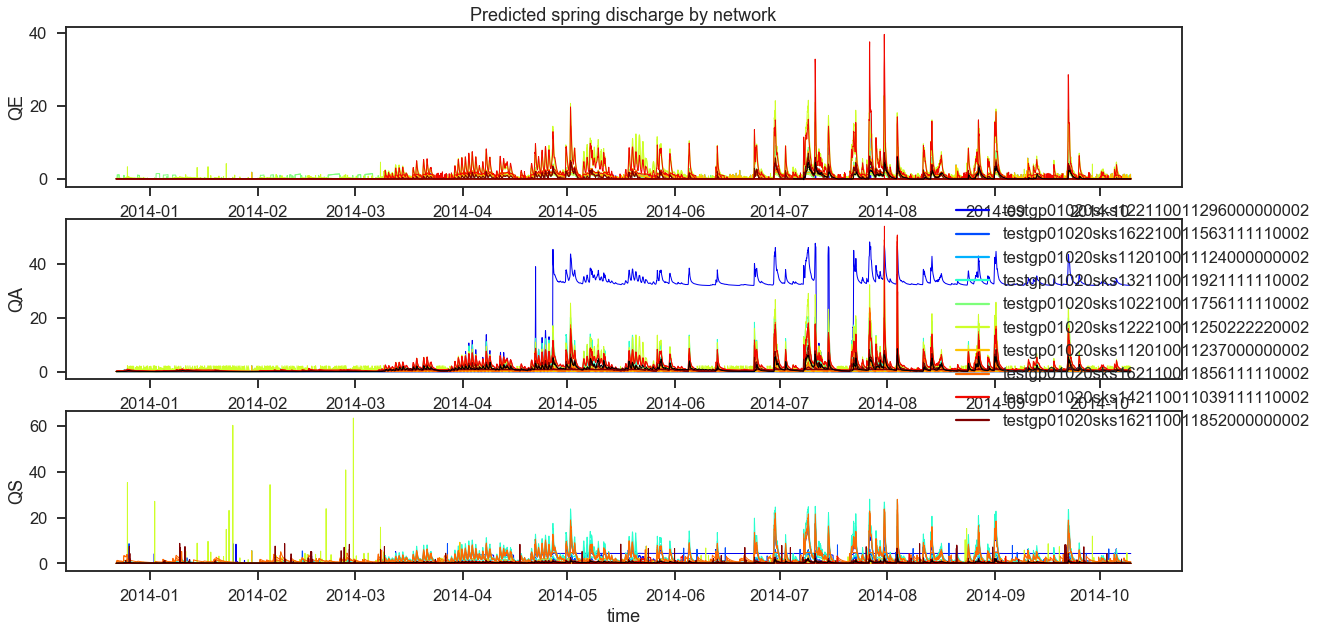

In [68]:
#Plot timeseries by SKS run (each color is all SWMM runs for one SKS network):
#Set up figure & axes:
f = plt.figure(figsize=(20,10))                         #create figure to plot on
ax=[plt.subplot(311),plt.subplot(312),plt.subplot(313)] #create subplots for spring Q
ax[0].set_ylabel('QE')                                  #set plot y labels
ax[1].set_ylabel('QA')
ax[2].set_ylabel('QS')
ax[0].set_title('Predicted spring discharge by network')
ax[2].set_xlabel('time')
cmap = matplotlib.cm.get_cmap('jet')                    #get colormap object to select colors from
colors = np.linspace(0.1,1,nruns['sks'])           #set up list of evenly-spaced color indices to use
patches=[]
#Loop over runs & plot:
for i in range(nruns['gempy']):             #loop over GemPy runs
    gpRunID = gpIDs[i]                      #get Gempy ID for current run
    for j in range(nruns['sks']):           #loop over SKS runs
        sksRunID = sksIDs[j]                #get SKS ID for current run 
        patches.append(matplotlib.lines.Line2D([0],[0],color=cmap(colors[j]), label=sksRunID)) #create custom patches and legend text
        for k in range(nrunsRound1):                                    #loop over SWMM runs (round 1)
            swmmRunID = sksRunID + 'swmmR1_' + restrictBehavior[k]      #create run ID string
            index = (gpRunID,sksRunID,swmmRunID)                        #create index for current run
            plotQ(data.loc[index, 'Q'], c=cmap(colors[j]))              #plot each run
plotQ(data.loc[('obs',0,0), 'Q'], c='k')                                #plot observed flow
#ax[0].legend(handles=patches)                                          #add custom legend to plot
f.legend(handles=patches, loc='right')

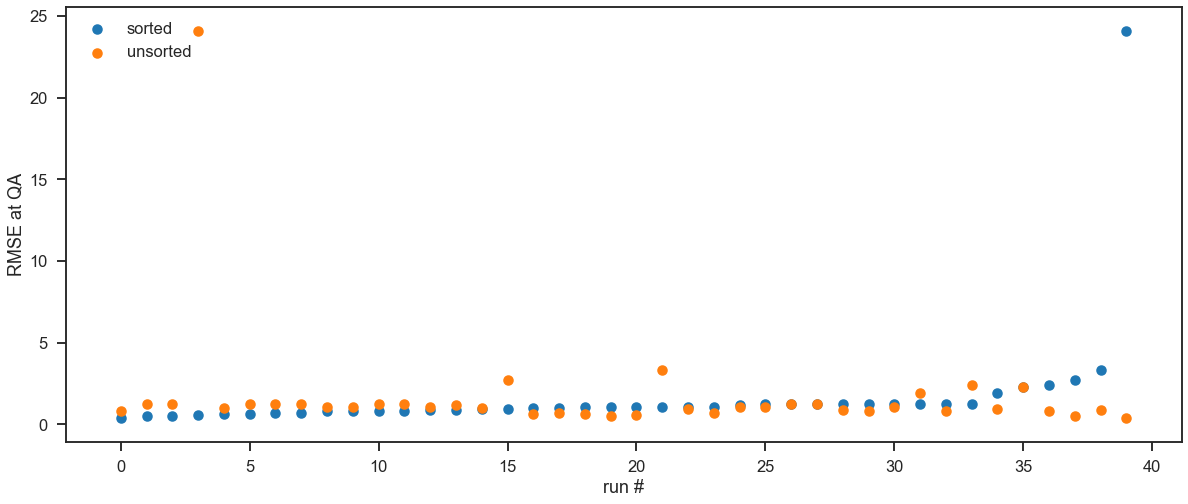

In [69]:
#Plot all SWMM runs sorted by RMSE:

#Plot all sorted:
metric = ('QA','RMSE')                                  #choose which metric to sort by
statsSort = stats.copy()                                #make a copy to avoid messing up original
statsSort.drop(columns=[('obs')],inplace=True)
statsSort.loc['run',:] = np.arange(len(statsSort.columns))  #insert new row with run number BEFORE sorting so that you can unsort later
statsSort = statsSort.sort_values([metric], axis=1)     #sort by metric
f,ax = plt.subplots(figsize=(20,8))
plt.scatter(np.arange(len(statsSort.columns)), statsSort.loc[metric])   #plot sorted scatter

#Plot all unsorted:
plt.scatter(statsSort.loc['run',:], statsSort.loc[metric])              #plot unsorted scatter
statsSort = statsSort.sort_values([('run','')], axis=1)                 #put back in original order

#Format plot:
plt.xlabel('run #')
plt.ylabel(metric[1]+' at '+ metric[0])
plt.legend(['sorted','unsorted'])
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True)) #force x tick labels to only be integers

total # of SKS runs: 10
# remaining round 1: 9
# remaining round 2: 8
# remaining round 3: 7
['testgp01020sks142110011039111110002swmmR1_low', 'testgp01020sks142110011039111110002swmmR1_QE', 'testgp01020sks142110011039111110002swmmR1_QA', 'testgp01020sks142110011039111110002swmmR1_QS', 'testgp01020sks102210011756111110002swmmR1_low', 'testgp01020sks102210011756111110002swmmR1_QE', 'testgp01020sks102210011756111110002swmmR1_QA', 'testgp01020sks102210011756111110002swmmR1_QS', 'testgp01020sks162110011852000000002swmmR1_low', 'testgp01020sks162110011852000000002swmmR1_QE', 'testgp01020sks162110011852000000002swmmR1_QA', 'testgp01020sks162110011852000000002swmmR1_QS', 'testgp01020sks112010011124000000002swmmR1_low', 'testgp01020sks112010011124000000002swmmR1_QE', 'testgp01020sks112010011124000000002swmmR1_QA', 'testgp01020sks112010011124000000002swmmR1_QS', 'testgp01020sks112010011237000000002swmmR1_low', 'testgp01020sks112010011237000000002swmmR1_QE', 'testgp01020sks112010011237000000002s

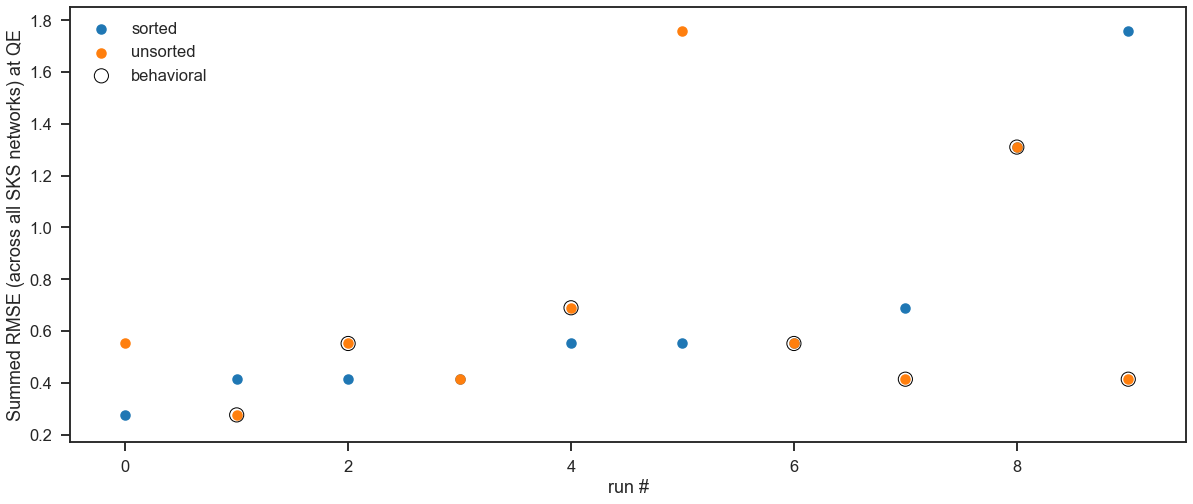

In [70]:
#Reject worst 10% of models as non-behavioral (~3% from each spring, using RMSE):

#Rescale error metrics (need rescaled for kmeans sorting later too):
statsScale = stats.loc[:,namesR1]  #copy just first-round runs (no obs) to avoid messing up original
for i in range(len(statsScale)):   #loop over rows of metrics
    s = statsScale.iloc[i].values  #get first metric
    s = s.reshape(-1, 1)           #turn into an nx1 column so sklearn knows all the values are part of one group
    scaler = sklearn.preprocessing.MinMaxScaler()  #create minmax scaler
    s = scaler.fit_transform(s)                    #rescale the data & overwrite
    statsScale.iloc[i] = s[:,0]     #overwrite row with rescaled values

#Get & sort run stats, then reject non-behavioral runs:
idx = pd.IndexSlice                             #create index object to make slicing easier
statsSum = statsScale.loc[:,namesR1]              #copy just round 1 scaled stats (not obs) to not mess up original
print('total # of SKS runs:', len(sksIDs))
#statsB.loc['run',:] = np.arange(len(statsB.columns))    #insert new row with run number

#Sum RMSE values across all round 1 SWMM runs, at each spring:
namesSum = []
for j in range(nruns['sks']):           #loop over SKS runs
    sksRunID = sksIDs[j]                #get SKS ID for current run 
    namesSum.append('sum'+sksRunID)     #store names of summed runs
    names = []                          #set up empty list for all SWMM runs on current SKS network
    for k in range(nrunsRound1):                                    #loop over SWMM runs (round 1)
        names.append(sksRunID + 'swmmR1_' + restrictBehavior[k])    #store name of current SWMM run
    statsSum.loc[idx[:,'RMSE'], 'sum'+sksRunID] = statsSum.loc[idx[:,'RMSE'], names].sum(axis=1) #store sum of RMSE across all SWMM runs

#Reject worst-performing 10% of SKS networks (rounded to integers):
#Reject 4% based on QE metrics:
statsB = statsSum.loc[idx[:,'RMSE'],namesSum]           #select dataframe of just summed RMSEs
statsB.loc['run',:] = np.arange(len(statsB.columns))    #insert new row with run number (to be able to sort later)
statsB = statsB.sort_values([('QE','RMSE'), ('QA','RMSE'), ('QS','RMSE')], axis=1)    #sort by summed RMSE
nkeep = int(len(sksIDs) - math.ceil(len(sksIDs)*0.04))  #calculate number of runs to keep 
statsB = statsB.iloc[:, :nkeep]                         #keep best 
print('# remaining round 1:', len(statsB.columns))

#Reject 3% based on QA metrics:
statsB = statsB.sort_values([('QA','RMSE'), ('QS','RMSE'), ('QE','RMSE')], axis=1)    #sort by metric
nkeep = int(len(statsB.columns) - math.ceil(len(sksIDs)*0.04))  #calculate number of runs to keep 
statsB = statsB.iloc[:, :nkeep]                                 #keep best
print('# remaining round 2:', len(statsB.columns))

#Reject 3% based on QS metrics:
statsB = statsB.sort_values([('QS','RMSE'), ('QE','RMSE'), ('QA','RMSE')], axis=1)    #sort by metric
nkeep = int(len(statsB.columns) - math.ceil(len(sksIDs)*0.04))  #calculate number of runs to keep 
statsB = statsB.iloc[:, :nkeep]                                 #keep best
print('# remaining round 3:', len(statsB.columns))

sksIDsB = [col[3:] for col in statsB.columns]    #save names of behavioral SKS runs (strip 'sum' prefix)
namesB = []
for col in statsB.columns:          #loop over behavioral SKS runs
    sksRunID = col[3:]              #strip 'sum' prefix 
    for k in range(nrunsRound1):                                    #loop over SWMM runs (round 1)
        namesB.append(sksRunID + 'swmmR1_' + restrictBehavior[k])   #store name of current SWMM run
print(namesB)
        
#Plot SKS runs sorted by cumulative RMSE:
spring = 'QE'
statsSort = statsSum.loc[:,namesSum]                            #make a copy to avoid messing up original
statsSort.loc['run',:] = np.arange(len(statsSort.columns))      #insert new row with run number (to be able to sort later)
statsSort = statsSort.sort_values([(spring,'RMSE')], axis=1)    #sort by summed spring RMSE
f,ax = plt.subplots(figsize=(20,8))
plt.scatter(np.arange(len(statsSort.columns)), statsSort.loc[(spring,'RMSE')])   #plot sorted scatter

#Plot all unsorted:
plt.scatter(statsSort.loc['run',:], statsSort.loc[(spring,'RMSE')]) #plot unsorted scatter
#statsSort = statsSort.sort_values([('run','')], axis=1)            #put back in original order

#Plot behavioral only:
statsB = statsB.sort_values([(spring,'RMSE')], axis=1)        #sort by summed spring RMSE
plt.scatter(statsB.loc['run',:], statsB.loc[(spring,'RMSE')], s=200, facecolors='none', edgecolors='k', linewidths=1)                #plot unsorted
plt.xlabel('run #')
plt.ylabel('Summed RMSE (across all SKS networks) at '+ spring)
plt.legend(['sorted','unsorted','behavioral'])
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True)) #force x tick labels to only be integers

                                     cluster
testgp01020sks142110011039111110002        1
testgp01020sks102210011756111110002        0
testgp01020sks162110011852000000002        1
testgp01020sks112010011124000000002        0
testgp01020sks112010011237000000002        0
testgp01020sks162210011563111110002        0
testgp01020sks162110011856111110002        2
sub ensemble: ['testgp01020sks102210011756111110002', 'testgp01020sks162110011852000000002', 'testgp01020sks162110011856111110002']


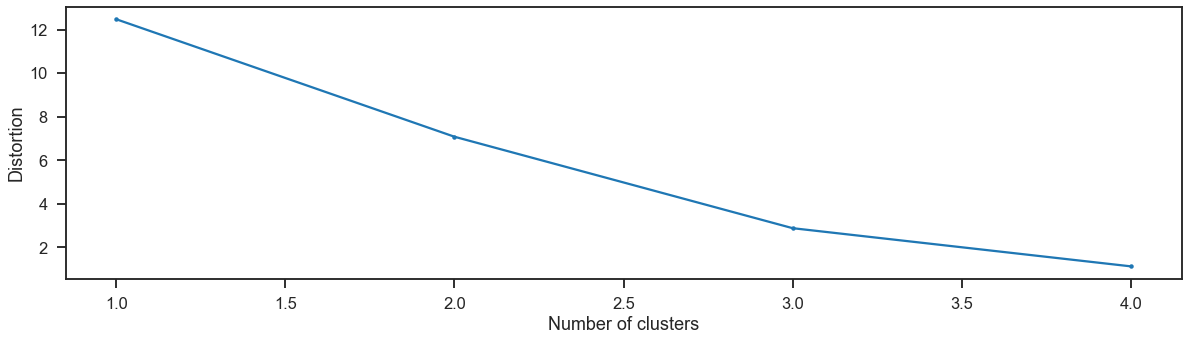

In [73]:
#K-means clustering for one SWMM run at a time for all springs, across all SKS networks
#with non-behavioral 10% of networks removed
#example of one metric: (QA, RMSE, idR1_0)

#Rescale error metrics:
statsScale = stats.loc[:,namesR1]   #copy just first-round runs to avoid messing up original
for i in range(len(statsScale)):   #loop over rows of metrics
    s = statsScale.iloc[i].values  #get first metric
    s = s.reshape(-1, 1)           #turn into an nx1 column so sklearn knows all the values are part of one group
    scaler = sklearn.preprocessing.MinMaxScaler()  #create minmax scaler
    s = scaler.fit_transform(s)                    #rescale the data & overwrite
    statsScale.iloc[i] = s[:,0]     #overwrite row with rescaled values

statsScale = statsScale.loc[:,namesB]    #copy just behavioralruns to avoid messing up original

#Format data for k-means clustering in 48 dimensions (3 springs x 4 SKS runs x 4 behavioral metrics):
clusters = pd.DataFrame(index=sksIDsB, columns=['cluster'], data=0) #create empty df to store cluster info

spring = 'QE'
cols = [col +'swmmR1_low' for col in sksIDsB]              #get column names for 1st SWMM run on all networks 
Ea0 = statsScale.loc[([spring],'meanQ'), cols].values[0]  #get stats for 1st spring, 1st metric, & 1st SWMM run on all SKS networks
Eb0 = statsScale.loc[([spring],'minQ'),  cols].values[0]  #get stats for 1st spring, 2nd metric, & 1st SWMM run on all SKS networks
Ec0 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  #get stats for 1st spring, 3rd metric, & 1st SWMM run on all SKS networks
Ed0 = statsScale.loc[([spring],'%lowQ'), cols].values[0]  #get stats for 1st spring, 4th metric, & 1st SWMM run on all SKS networks
cols = [col +'swmmR1_QE' for col in sksIDsB]                #get column names for 2nd SWMM run on all networks 
Ea1 = statsScale.loc[([spring],'meanQ'), cols].values[0]  #get stats for 1st spring, 1st metric, & 2nd SWMM run on all SKS networks
Eb1 = statsScale.loc[([spring],'minQ'),  cols].values[0]  #etc.
Ec1 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Ed1 = statsScale.loc[([spring],'%lowQ'), cols].values[0] 
cols = [col +'swmmR1_QA' for col in sksIDsB]  
Ea2 = statsScale.loc[([spring],'meanQ'), cols].values[0] 
Eb2 = statsScale.loc[([spring],'minQ'),  cols].values[0] 
Ec2 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Ed2 = statsScale.loc[([spring],'%lowQ'), cols].values[0] 
cols = [col +'swmmR1_QS' for col in sksIDsB]    
Ea3 = statsScale.loc[([spring],'meanQ'),  cols].values[0] 
Eb3 = statsScale.loc[([spring],'minQ'),  cols].values[0] 
Ec3 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Ed3 = statsScale.loc[([spring],'%lowQ'), cols].values[0]

spring = 'QA'
cols = [col +'swmmR1_low' for col in sksIDsB]   
Aa0 = statsScale.loc[([spring],'meanQ'), cols].values[0]  #get stats for 2st spring, 1st metric, & 1st SWMM run on all SKS networks
Ab0 = statsScale.loc[([spring],'minQ'),  cols].values[0]  
Ac0 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Ad0 = statsScale.loc[([spring],'%lowQ'), cols].values[0]  
cols = [col +'swmmR1_QE' for col in sksIDsB]   
Aa1 = statsScale.loc[([spring],'meanQ'), cols].values[0]
Ab1 = statsScale.loc[([spring],'minQ'),  cols].values[0]  
Ac1 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Ad1 = statsScale.loc[([spring],'%lowQ'), cols].values[0] 
cols = [col +'swmmR1_QA' for col in sksIDsB]  
Aa2 = statsScale.loc[([spring],'meanQ'), cols].values[0] 
Ab2 = statsScale.loc[([spring],'minQ'),  cols].values[0] 
Ac2 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Ad2 = statsScale.loc[([spring],'%lowQ'), cols].values[0] 
cols = [col +'swmmR1_QS' for col in sksIDsB]       
Aa3 = statsScale.loc[([spring],'meanQ'),  cols].values[0] 
Ab3 = statsScale.loc[([spring],'minQ'),  cols].values[0] 
Ac3 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Ad3 = statsScale.loc[([spring],'%lowQ'), cols].values[0]

spring = 'QS'
cols = [col +'swmmR1_low' for col in sksIDsB]  
Sa0 = statsScale.loc[([spring],'meanQ'), cols].values[0]  
Sb0 = statsScale.loc[([spring],'minQ'),  cols].values[0]  
Sc0 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Sd0 = statsScale.loc[([spring],'%lowQ'), cols].values[0]  
cols = [col +'swmmR1_QE' for col in sksIDsB]
Sa1 = statsScale.loc[([spring],'meanQ'), cols].values[0]
Sb1 = statsScale.loc[([spring],'minQ'),  cols].values[0]  
Sc1 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Sd1 = statsScale.loc[([spring],'%lowQ'), cols].values[0] 
cols = [col +'swmmR1_QA' for col in sksIDsB]      
Sa2 = statsScale.loc[([spring],'meanQ'), cols].values[0] 
Sb2 = statsScale.loc[([spring],'minQ'),  cols].values[0] 
Sc2 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Sd2 = statsScale.loc[([spring],'%lowQ'), cols].values[0] 
cols = [col +'swmmR1_QS' for col in sksIDsB]       
Sa3 = statsScale.loc[([spring],'meanQ'),  cols].values[0] 
Sb3 = statsScale.loc[([spring],'minQ'),  cols].values[0] 
Sc3 = statsScale.loc[([spring],'maxQ'),  cols].values[0]  
Sd3 = statsScale.loc[([spring],'%lowQ'), cols].values[0]

X = np.column_stack((Ea0,Ea1,Ea2,Ea3, Eb0,Eb1,Eb2,Eb3, Ec0,Ec1,Ec2,Ec3, Ed0,Ed1,Ed2,Ed3,
                     Aa0,Aa1,Aa2,Aa3, Ab0,Ab1,Ab2,Ab3, Ac0,Ac1,Ac2,Ac3, Ad0,Ad1,Ad2,Ad3,
                     Sa0,Sa1,Sa2,Sa3, Sb0,Sb1,Sb2,Sb3, Sc0,Sc1,Sc2,Sc3, Sd0,Sd1,Sd2,Sd3))   #combine into array
#print(X.shape)                      #should be (# of SKS models, # of metrics/dimensions)

#Check optimal number of clusters using elbow method:
#look at plot and make sure the number of clusters is above the sharp increase in distortion
nClusters = 3                                      #assign inital guess at number of clusters
distortions = []
for j in range(1, nClusters+2):
    kmean = sklearn.cluster.KMeans(n_clusters=j)    #calculate kmeans using different numbers of clusters
    kmean.fit(X)                                    #get clusters
    distortions.append(kmean.inertia_)              #store inertia for different numbers of clusters
f,ax = plt.subplots(1,1, figsize=(20,5))            #set up plot
ax.plot(range(1, nClusters+2), distortions, marker='.')      #plot distortion curve
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Distortion')

#Get clustering:
#nClusters = 10
#nClusters = 3                                           #update number of clusters based on elbow graph
kmeans = sklearn.cluster.KMeans(n_clusters=nClusters)
clusters['cluster'] = kmeans.fit_predict(X)             #list of each run's assigned cluster #
centers = []
for m in range(X.shape[1]):                             #loop over number of metrics
    center = kmeans.cluster_centers_[:, m]              #get coordinates of cluster center
    centers.append(center)                              #store coordinates of cluster center
#print(np.shape(centers))                                #(# of metrics, # of clusters)
print(clusters)                     

#Choose a representative model run from each cluster:
#Pick randomly within cluster (could eventually use shortest distance to cluster center)
subEnsemble = []
for c in range(nClusters):                   #loop over clusters
    ind = np.where(clusters.cluster==c)[0]   #get indices of all SKS runs in cluster
    i = random.choice(ind)                   #randomly choose SKS run within cluster
    runID = clusters.index[i]                #get name of that SKS run
    subEnsemble.append(runID)                #store name
print('sub ensemble:', subEnsemble)

### Second-round SWMM runs: many parameters sets on a sub-ensemble of SKS networks ###
Run a large number of parameter sets on a diverse sub-ensemble of SKS networks

In [74]:
#SWMM runs:
#Set up parameter key string tracking & select parameters:
for i in range(nruns['gempy']):                 #loop over GemPy runs
    gpRunID = gpIDs[i]                          #get Gempy ID for current run
    allIDs.append(gpRunID[-len(gpParInd):])     #append to list of parameter key strings
    print('gpRunID',gpRunID)
    
    for j in range(len(subEnsemble)):           #loop over SKS sub-ensemble
        sksRunID = subEnsemble[j]               #get SKS ID for current run
        allIDs.append(gpRunID[-len(gpParInd):] + sksRunID[-len(sksParInd):])     #append to list of parameter key strin
        print('sksRunID',sksRunID)
        
        #Set up components that depend only on conduit network (will be same for all SWMM runs):
        #Load SKS network:
        nodes, links = sp.sks2swmm(os.path.join(output_path,sksRunID+nodes_file), 
                                   os.path.join(output_path,sksRunID+links_file), 
                                   spring_path, dim=3, simplify=True)            #import node and link data from SKS outputs
                
        #Network-based sections: 
        junctions = sp.set_junctions(nodes, maxdepth=0, initdepth=0, surdepth=200, aponded=0)
        outfalls = sp.set_outfalls(nodes, outtype='FREE', stage='', tidegate='NO')
        conduits = sp.set_conduits(links, nodes, manningN=0.01, inoffset='*', outoffset='*', initflow=0, maxflow=0)
        coordinates = sp.set_coordinates(nodes)

        #Subcatchments-based sections:
        catchs, areas = sp.import_subcatchments(dem_path, nodes=nodes, find_widths=False, mask_array=dema_karst)    #calculate subcatchments for karst catchment only
        raingages = sp.set_raingages(nodes, raintype='VOLUME', tintvl='1:00', snowctch=1.0, datatype='TIMESERIES') #assign a raingage to each subcatchment
        subcatchments = sp.set_subcatchments(nodes, catch=catchs, areas=areas, width='auto', pctimpv=100, slope=0.25, curblen=0, snowpack='', plot=False)
        subareas = sp.set_subareas(nodes, nimperv=0.2, nperv=0.1, simperv=0.15, sperv=0.05, pctzero=100, routeto='IMPERVIOUS', pctrouted=100)
        infiltration = sp.set_infiltration(nodes, maxrate=3, minrate=0.5, decay=4, drytime=7, maxinfil=0)
        inflows = sp.set_inflows(nodes, catchs, par='FLOW', partype='FLOW', unitfactor=1.0, scalefactor=1.0, baseval='', basepattern='')

        #Timeseries:
        print('recalculating timeseries')
        rainfall, baseflow, catchPoly = sp.get_timeseries(rainfallgrid, baseflowgrid, grid, nodes, catchs, datetimes, [xres,yres,zres,xmin,ymin,zmin,xmax,ymax,zmax])
        timeseries = sp.set_timeseries([rainfall, baseflow], ['Rainfall', 'Baseflow'], nodes, timestrings)  #create a formatted df to insert

        #Report:
        rnodes = str(outfalls.Name.values)                      #get node name for all springs
        rlinks = str(conduits.Name.iloc[-5:].values)            #get conduit names for last 5 conduits
        rnodes = rnodes.replace('[','').replace(']','')         #strip brackets from string (there is probably a prettier way of doing this)
        rlinks = rlinks.replace('[','').replace(']','')         #strip brackets from string (there is probably a prettier way of doing this)
        report = sp.set_report(rnodes, rlinks)
        
        for k in range(nruns['swmm']):          #loop over SWMM runs
            swmmRunPars = {}                    #create empty dic to store current run parameter values
            swmmParKey = k      
            allIDs.append(gpRunID[-len(gpParInd):] + sksRunID[-len(sksParInd):] + str(swmmParKey))   #append complete parameter key string       
            swmmRunID = sksRunID + 'swmm' + str(swmmParKey)     #create run ID string
            swmmIDs.append(swmmRunID)                           #append to list
            swmmPars[swmmRunID] = swmmRunPars                   #add current run par values to dic of all swmm pars
            print('Starting SWMM run ' + str(i) + '-' + str(j) + '-' + str(k)
                  + ': ' + swmmRunID)           
                       
            index = (gpRunID,sksRunID,swmmRunID)                #set index for data storage
            name = swmmRunID                                    #set name for stats calculation
            print(index)
    
            run = True
            if run == True:
    
                #Set up diameters (probability-weighted random choice with no replacement):
                diameters = np.full(len(links), 4.0) #make list of diameters and set to wide value
                order, *_ = sp.get_order(nodes, links, areas, alpha=0.1, beta=0.001)  #calculate conduit order
                weights = np.asarray([float(i)/sum(order) for i in order])  #normalize order to sum to 1 to be used as probabilities
                k = random.randint(1,len(weights[np.nonzero(weights)]))     #randomly select how many conduits to restrict from nonzero-weight conduits
                restrict = np.random.choice(links.Name.values, size=k, p=weights, replace=False)   #choose conduits to restrict
                diameters[restrict] = 1.0           #assign a narrow diameter to the selected conduits
                xsections = sp.set_xsections(links, shape='FORCE_MAIN', g1=diameters, g2=1000.0, g3=0, g4=0, barrels=1, culvert='')

                #Write new input file:    
                swmm_data = [ raingages, subcatchments, subareas, infiltration, junctions, outfalls, conduits, 
                             xsections, inflows, timeseries, report, coordinates]  #group data dataframes into a list
                inputfile = os.path.join(output_path,swmmRunID+swmm_inputfile)                                           #create filepath to save input file with IDs
                sp.write_input(inputfile, swmm_placeholders, swmm_data, template_filename=swmm_template_file)       #write new input files from template
                
                #Run SWMM with new .inp and generate .rpt and .out files
                reportfile = os.path.join(output_path,swmmRunID+swmm_reportfile)  #create filepath to save report file with ID
                outputfile = os.path.join(output_path,swmmRunID+swmm_outputfile)  #create filepath to save output file with ID
                
                run=True
                if run==True:
                    sp.run(inputfile, reportfile, outputfile)                   #run SWMM as a subprocess

                #Get and store stats:
                Q = pd.DataFrame(index=Qobs.index)          #create an empty dataframe with preset timesteps based on the observed discharge data
                columns = ['QE','QA','QS','Surface']        #list of column names to use in df
                try:
                    Q = sp.getQ(outputfile, Q, columns)     #extract data from SWMM output file
                except:                                     #if there is an import error (probably because the SWMM run didn't complete)
                    Q['QE'] = np.nan                        #insert nans
                    Q['QA'] = np.nan
                    Q['QS'] = np.nan    
                Q = Q*u                             #convert units
                data.loc[index, 'Q'] = 0            #create new row at [(row,sub-row,sub-sub-row),column] because otherwise df.at[] won't work
                data.at[ index, 'Q'] = Q            #insert data df at [(row,sub-row,sub-sub-row),column] (must use df.at[] and not df.loc[])
                data.at[ index, 'diameters'] = diameters    #insert diameter list
                data = data.sort_index()                    #sort so that the sub-row shows up below the original & not at the bottom
                stats = calcErrors(Q, Qobs, name, stats)    #calculate and store error stats for this run
                          
print('Done with SWMM runs.')

gpRunID testgp01020
sksRunID testgp01020sks102210011756111110002
importing & simplifying network

Graph successfully created from file !

assigning springs by adding spring nodes and linking to closest junction node
assigning subcatchments to nodes automatically using pysheds
resolving duplicates
calculating width
recalculating timeseries
Starting SWMM run 0-0-0: testgp01020sks102210011756111110002swmm0
('testgp01020', 'testgp01020sks102210011756111110002', 'testgp01020sks102210011756111110002swmm0')
Int64Index([49], dtype='int64') raingages
Int64Index([326], dtype='int64') subcatchments
Int64Index([603], dtype='int64') subareas
Int64Index([880], dtype='int64') infiltration
Int64Index([1157], dtype='int64') junctions
Int64Index([1431], dtype='int64') outfalls
Int64Index([1438], dtype='int64') conduits
Int64Index([1813], dtype='int64') xsections
Int64Index([2192], dtype='int64') inflows
Int64Index([2469], dtype='int64') timeseries
Int64Index([4326793], dtype='int64') report
Int64Index([

Text(0.5, 1.0, 'Predicted spring discharge')

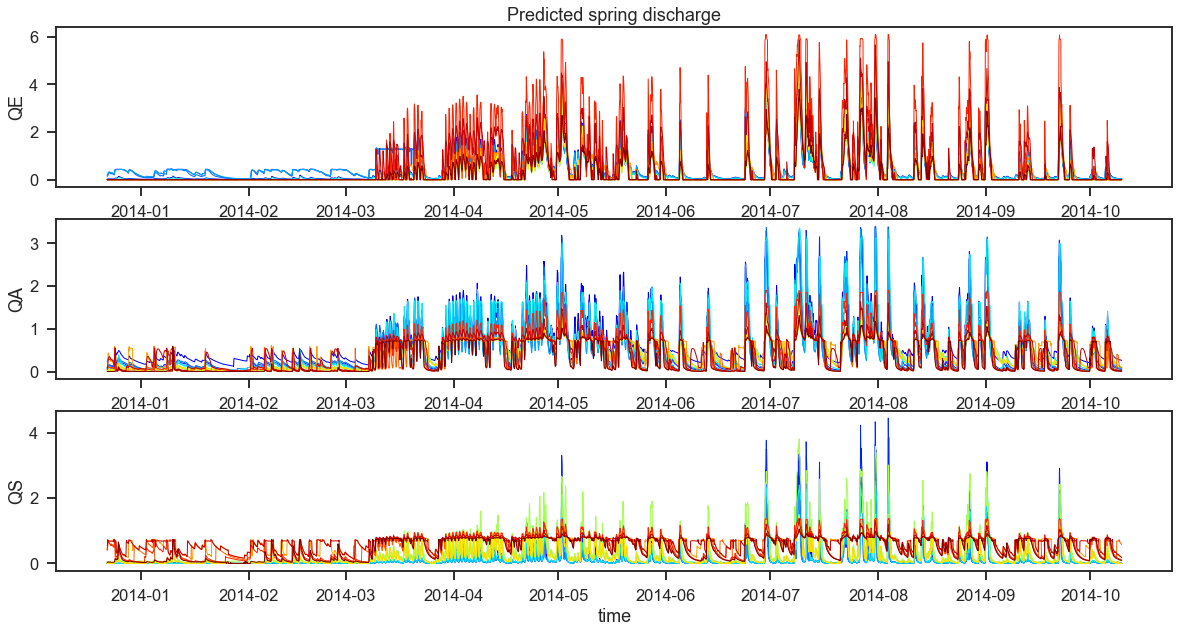

In [80]:
#Optional: plot spring discharge data:
#Create list of round 2 runs to plot:
names = []
indices = []
for i in range(nruns['gempy']):                #loop over GemPy runs
    gpRunID = gpIDs[i]                         #get Gempy ID for current run
    for j in range(len(subEnsemble)):           #loop over SKS sub-ensemble
        sksRunID = subEnsemble[j]               #get SKS ID for current run 
        for k in range(nruns['swmm']):
            swmmRunID = sksRunID + 'swmm' + str(k)   #create run ID string
            index = (gpRunID,sksRunID,swmmRunID)   #set index for data storage
            name = swmmRunID                       #set name for stats calculation\
            indices.append(index)
            names.append(name)

#PLot timeseries:
f = plt.figure(figsize=(20,10))                         #create figure to plot on
ax=[plt.subplot(311),plt.subplot(312),plt.subplot(313)] #create subplots for spring Q
cmap = matplotlib.cm.get_cmap('jet')                    #get colormap object to select colors from
colors = np.linspace(0.1,1,len(names))                  #set up list of evenly-spaced color indices to use
for i in range(len(names)):                             #loop over runs
    plotQ(data.loc[indices[i], 'Q'], c=cmap(colors[i])) #plot each run
ax[0].set_ylabel('QE')
ax[1].set_ylabel('QA')
ax[2].set_ylabel('QS')
ax[2].set_xlabel('time')
ax[0].set_title('Predicted spring discharge')

#### Export ensemble data

In [87]:
#Export model IDs:
allIDs        = pd.DataFrame([gpIDs, sksIDs, swmmIDs],index=['gpIDs','sksIDs','swmmIDs']).transpose()
allIDs.to_csv(os.path.join(output_path, ID+'IDs.csv'), index=False)
subEnsembledf = pd.DataFrame(subEnsemble)
subEnsembledf.to_csv(os.path.join(output_path, ID+'subEnsemble.csv'), index=False)
sksIDsBdf     = pd.DataFrame(sksIDsB)
sksIDsBdf.to_csv(os.path.join(output_path, ID+'sksIDsB.csv'), index=False)
nrunsdf       = pd.DataFrame.from_dict(nruns, orient='index').T
nrunsdf.to_csv(os.path.join(output_path, ID+'nruns.csv'), index=False)

#Export model parameters:
restrictBehaviordf = pd.DataFrame(restrictBehavior)
restrictBehaviordf.to_csv(os.path.join(output_path, ID+'restrictBehavior.csv'), index=False)
allPars = pd.DataFrame({**gpPars,**sksPars,**swmmPars}) #merge par dics into one dic and convert to df
allPars.to_csv(os.path.join(output_path, ID+'pars.csv'))    #export as csv
    
#Export data and stats:
data.to_csv(os.path.join(output_path,ID+'data.csv'))
stats.to_csv(os.path.join(output_path,ID+'stats.csv'))


### Generate SWMM runs for base network ###
Runs base network using same procedures (auto-catchment delineation, randomly-restricted diameters). <br>
Only need to run once, to generate stats for comparison

In [84]:
#SWMM runs for base network:
#Set up parameter key string tracking & select parameters:
i=np.nan
j=np.nan
gpRunID  = 'base'               #manually set GemPy ID
sksRunID = 'base'               #set SKS ID for current run
print('sksRunID',sksRunID)

#Set up components that depend only on conduit network (will be same for all SWMM runs):
#Load SKS network:
nodes, links = sp.sks2swmm(base_nodes_file, base_links_file, spring_path, dim=3, simplify=False)            #import node and link data from SKS outputs

#Network-based sections: 
junctions = sp.set_junctions(nodes, maxdepth=0, initdepth=0, surdepth=200, aponded=0)
outfalls = sp.set_outfalls(nodes, outtype='FREE', stage='', tidegate='NO')
conduits = sp.set_conduits(links, nodes, manningN=0.01, inoffset='*', outoffset='*', initflow=0, maxflow=0)
coordinates = sp.set_coordinates(nodes)

#Subcatchments-based sections:
catchs, areas = sp.import_subcatchments(dem_path, nodes=nodes, find_widths=False, mask_array=dema_karst)    #calculate subcatchments for karst catchment only
raingages = sp.set_raingages(nodes, raintype='VOLUME', tintvl='1:00', snowctch=1.0, datatype='TIMESERIES') #assign a raingage to each subcatchment
subcatchments = sp.set_subcatchments(nodes, catch=catchs, areas=areas, width='auto', pctimpv=100, slope=0.25, curblen=0, snowpack='', plot=False)
subareas = sp.set_subareas(nodes, nimperv=0.2, nperv=0.1, simperv=0.15, sperv=0.05, pctzero=100, routeto='IMPERVIOUS', pctrouted=100)
infiltration = sp.set_infiltration(nodes, maxrate=3, minrate=0.5, decay=4, drytime=7, maxinfil=0)
inflows = sp.set_inflows(nodes, catchs, par='FLOW', partype='FLOW', unitfactor=1.0, scalefactor=1.0, baseval='', basepattern='')

#Timeseries:
print('recalculating timeseries')
rainfall, baseflow, catchPoly = sp.get_timeseries(rainfallgrid, baseflowgrid, grid, nodes, catchs, datetimes, [xres,yres,zres,xmin,ymin,zmin,xmax,ymax,zmax])
timeseries = sp.set_timeseries([rainfall, baseflow], ['Rainfall', 'Baseflow'], nodes, timestrings)  #create a formatted df to insert

#Report:
rnodes = str(outfalls.Name.values)                      #get node name for all springs
rlinks = str(conduits.Name.iloc[-5:].values)            #get conduit names for last 5 conduits
rnodes = rnodes.replace('[','').replace(']','')         #strip brackets from string (there is probably a prettier way of doing this)
rlinks = rlinks.replace('[','').replace(']','')         #strip brackets from string (there is probably a prettier way of doing this)
report = sp.set_report(rnodes, rlinks)

for k in range(nruns['swmm']):          #loop over SWMM runs
    swmmRunPars = {}                    #create empty dic to store current run parameter values
    swmmParKey = k      
    swmmRunID = sksRunID + 'swmm' + str(swmmParKey)     #create run ID string
    swmmIDs.append(swmmRunID)                           #append to list
    print('Starting SWMM run ' + str(k) + ': ' + swmmRunID)           

    index = (gpRunID,sksRunID,swmmRunID)                #set index for data storage
    name = swmmRunID                                    #set name for stats calculation
    print(index)

    #Set up diameters (probability-weighted random choice with no replacement):
    diameters = np.full(len(links), 4.0) #make list of diameters and set to wide value
    order, *_ = sp.get_order(nodes, links, areas, alpha=0.1, beta=0.001)  #calculate conduit order
    weights = np.asarray([float(i)/sum(order) for i in order])  #normalize order to sum to 1 to be used as probabilities
    k = random.randint(1,len(weights[np.nonzero(weights)]))     #randomly select how many conduits to restrict from nonzero-weight conduits
    restrict = np.random.choice(links.Name.values, size=k, p=weights, replace=False)   #choose conduits to restrict
    diameters[restrict] = 1.0           #assign a narrow diameter to the selected conduits
    xsections = sp.set_xsections(links, shape='FORCE_MAIN', g1=diameters, g2=1000.0, g3=0, g4=0, barrels=1, culvert='')

    #Write new input file:    
    swmm_data = [ raingages, subcatchments, subareas, infiltration, junctions, outfalls, conduits, xsections, inflows, timeseries, report, coordinates]  #group data dataframes into a list
    inputfile = os.path.join(output_path,swmmRunID+swmm_inputfile)                                           #create filepath to save input file with IDs
    sp.write_input(inputfile, swmm_placeholders, swmm_data, template_filename=swmm_template_file)       #write new input files from template

    #Run SWMM with new .inp and generate .rpt and .out files
    reportfile = os.path.join(output_path,swmmRunID+swmm_reportfile)  #create filepath to save report file with ID
    outputfile = os.path.join(output_path,swmmRunID+swmm_outputfile)  #create filepath to save output file with ID
    sp.run(inputfile, reportfile, outputfile)                   #run SWMM as a subprocess

    #Get and store stats:
    Q = pd.DataFrame(index=Qobs.index)          #create an empty dataframe with preset timesteps based on the observed discharge data
    columns = ['QE','QA','QS','Surface']        #list of column names to use in df
    try:
        Q = sp.getQ(outputfile, Q, columns)     #extract data from SWMM output file
    except:                                     #if there is an import error (probably because the SWMM run didn't complete)
        Q['QE'] = np.nan                        #insert nans
        Q['QA'] = np.nan
        Q['QS'] = np.nan    
    Q = Q*u                             #convert units
    data.loc[index, 'Q'] = 0            #create new row at [(row,sub-row,sub-sub-row),column] because otherwise df.at[] won't work
    data.at[ index, 'Q'] = Q            #insert data df at [(row,sub-row,sub-sub-row),column] (must use df.at[] and not df.loc[])
    data.at[ index, 'diameters'] = diameters    #insert diameter list
    data = data.sort_index()                    #sort so that the sub-row shows up below the original & not at the bottom
    stats = calcErrors(Q, Qobs, name, stats)    #calculate and store error stats for this run
               
print('Done with SWMM runs.')

sksRunID base
importing unsimplified network
assigning springs by adding spring nodes and linking to closest junction node
assigning subcatchments to nodes automatically using pysheds
resolving duplicates
calculating width
recalculating timeseries
Starting SWMM run 0: baseswmm0
('base', 'base', 'baseswmm0')
Int64Index([49], dtype='int64') raingages
Int64Index([92], dtype='int64') subcatchments
Int64Index([135], dtype='int64') subareas
Int64Index([178], dtype='int64') infiltration
Int64Index([221], dtype='int64') junctions
Int64Index([261], dtype='int64') outfalls
Int64Index([268], dtype='int64') conduits
Int64Index([310], dtype='int64') xsections
Int64Index([356], dtype='int64') inflows
Int64Index([399], dtype='int64') timeseries
Int64Index([618163], dtype='int64') report
Int64Index([618178], dtype='int64') coordinates


 o  Retrieving project data

... EPA-SWMM 5.1 (Build 5.1.13)





... EPA-SWMM completed in 2110.00 seconds. There are warnings.

Starting SWMM run 1: baseswmm1
('base

In [88]:
#Re-export data updated with reference model runs:
data.to_csv(os.path.join(output_path,  ID+'data.csv'))
stats.to_csv(os.path.join(output_path, ID+'statsReference.csv')) #stats for all runs PLUS reference runs
